In [1]:
#import packages
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score

#to plot within notebook
import matplotlib.pyplot as plt


#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
def moving_average(df,p):#Here df is the input dataframe and p is the train test split cut-off
    #setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]
    
    cutoff=math.floor(len(df)*p)
    #split into train and validation
    train = new_data[:cutoff+1]
    valid = new_data[cutoff+1:]

    #make predictions
    preds = []
    for i in range(0,len(df)-cutoff-1):
        a = train['Close'][len(train)-(len(df)-cutoff-1)+i:].sum() + sum(preds)
        b = a/(len(df)-cutoff-1)
        preds.append(b)

    #calculate rmse
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
    print("Moving average rms : " + str(rms))
    print("Moving average r-squared score is : " + str(r2_score(valid["Close"],preds)))

    #plot
    %matplotlib inline
    valid['Predictions'] = 0
    valid['Predictions'] = preds
    plt.figure(figsize=(20,8))
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    return

In [3]:
def linear_regression(df,p):#Here df is the input dataframe and p is the train test split cut-off
    #setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

   #create features
    from fastai.tabular import  add_datepart
    add_datepart(new_data, 'Date')
    new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
    
    new_data['mon_fri'] = 0
    for i in range(0,len(new_data)):
        if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
            new_data['mon_fri'][i] = 1
        else:
            new_data['mon_fri'][i] = 0
    cutoff=math.floor(len(df)*p)
    #split into train and validation
    train = new_data[:cutoff+1]
    valid = new_data[cutoff+1:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']

    ##implement linear regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x_train,y_train)

    #make predictions and find the rmse
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print("Linear Regression RMS score is :" + str(rms))        
    print("Linear Regression r-squared score is : " + str(r2_score(y_valid,preds)))
    %matplotlib inline

    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = preds

    valid.index = new_data[cutoff+1:].index
    train.index = new_data[:cutoff+1].index
    plt.figure(figsize=(20,8))
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    return 

In [4]:
def KNN(df,p):#Here df is the input dataframe and p is the train test split cut-off
    from sklearn import neighbors
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
     #setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

   #create features
    from fastai.tabular import  add_datepart
    add_datepart(new_data, 'Date')
    new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
    
    new_data['mon_fri'] = 0
    for i in range(0,len(new_data)):
        if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
            new_data['mon_fri'][i] = 1
        else:
            new_data['mon_fri'][i] = 0
    cutoff=math.floor(len(df)*p)
    #split into train and validation
    train = new_data[:cutoff+1]
    valid = new_data[cutoff+1:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']    
    #scaling data
    x_train_scaled = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(x_valid)
    x_valid = pd.DataFrame(x_valid_scaled)

    #using gridsearch to find the best parameter
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)

    #fit the model and make predictions
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)

    #rmse
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print("k nearest neighbors RMS : " + str(rms))
    print("Linear Regression r-squared score is : " + str(r2_score(y_valid,preds)))

    plt.rcParams['figure.figsize'] = [10,6]
    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = preds
    plt.figure(figsize=(20,8))
    plt.plot(valid[['Close', 'Predictions']])
    plt.plot(train['Close'])
    return

In [5]:
def fbprophet(df,p):#Here df is the input dataframe and p is the train test split cut-off
    from fbprophet import Prophet
    
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #setting index as date values
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #sorting
    data = df.sort_index(ascending=True, axis=0)

    #creating dataframe
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
    new_data.index = new_data['Date']

    #preparing data
    new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

    cutoff=math.floor(len(df)*p)
    #split into train and validation
    train = new_data[:cutoff+1]
    valid = new_data[cutoff+1:]
    
    #fit the model
    model = Prophet(daily_seasonality = True)
    model.fit(train)

    #predictions
    close_prices = model.make_future_dataframe(periods=len(valid))
    forecast = model.predict(close_prices)

    #rmse
    forecast_valid = forecast['yhat'][cutoff+1:]
    rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
    print("Prophet RMS is : " + str(rms))
    print("R-squared score is : " + str(r2_score(np.array(valid['y']),np.array(forecast_valid))))

    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = forecast_valid.values
    plt.figure(figsize=(20,8))
    plt.plot(train['y'])
    plt.plot(valid[['y', 'Predictions']])
    return 

In [6]:
def ARIMA(df,p):#Here df is the input dataframe and p is the train test split cut-off
    from pyramid.arima import auto_arima

    data = df.sort_index(ascending=True, axis=0)

    cutoff=math.floor(len(df)*p)
    #split into train and validation
    train = data[:cutoff+1]
    valid = data[cutoff+1:]

    training = train['Close']
    validation = valid['Close']

    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)#It is basically as SARIMA model
    model.fit(training)

    forecast = model.predict(n_periods=len(df)-cutoff-1)
    forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
    print("ARIMA RMS is : " + str(rms))
    print("R-squared score is : " + str(r2_score(np.array(valid['Close']),np.array(forecast['Prediction']))))
    #plot SARIMSA
    plt.figure(figsize=(20,8))
    plt.plot(train['Close'])
    plt.plot(valid['Close'])
    plt.plot(forecast['Prediction'])
    return

In [7]:
def LSTM(df,p):#Here df is the input dataframe and p is the train test split cut-off
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, LSTM
    #
    #creating dataframe
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    #setting index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

    #creating train and test sets
    dataset = new_data.values
    cutoff=math.floor(len(df)*p)
    train = dataset[0:cutoff+1,:]
    valid = dataset[cutoff+1:,:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    ##
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    #predicting remaining values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print("LSTM " + str(rms))
    print("LSTM r-squared score is : " + str(r2_score(valid,closing_price)))
    
    #for plotting LSTM
    train = new_data[:cutoff+1]
    valid = new_data[cutoff+1:]
    
    valid['Predictions'] = closing_price
    plt.figure(figsize=(20,8))
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    return

Now we are going to fit the above models on different stocks from NYSE and look into their predicting efficacy.

In [8]:
stock=pd.read_csv("prices-split-adjusted.csv")

In [9]:
stock.columns=["Date","Symbol","Open","Close","Low","High","Volume"]
stock.head()

Date Symbol        Open       Close         Low        High  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      Volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [10]:
Tickers=list(set(stock["Symbol"]))
Tickers.sort()
Tickers

['A',
 'AAL',
 'AAP',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADS',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AET',
 'AFL',
 'AGN',
 'AIG',
 'AIV',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALK',
 'ALL',
 'ALLE',
 'ALXN',
 'AMAT',
 'AME',
 'AMG',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'AON',
 'APA',
 'APC',
 'APD',
 'APH',
 'ARNC',
 'ATVI',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXP',
 'AYI',
 'AZO',
 'BA',
 'BAC',
 'BAX',
 'BBBY',
 'BBT',
 'BBY',
 'BCR',
 'BDX',
 'BEN',
 'BHI',
 'BIIB',
 'BK',
 'BLK',
 'BLL',
 'BMY',
 'BSX',
 'BWA',
 'BXP',
 'C',
 'CA',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBG',
 'CBS',
 'CCI',
 'CCL',
 'CELG',
 'CERN',
 'CF',
 'CFG',
 'CHD',
 'CHK',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COG',
 'COH',
 'COL',
 'COO',
 'COP',
 'COST',
 'COTY',
 'CPB',
 'CRM',
 'CSCO',
 'CSRA',
 'CSX',
 'CTAS',
 'CTL',
 'CTSH',
 'CTXS',
 'CVS',
 'CVX',
 'CXO',
 'D',
 'DAL',


In [11]:
df={}
for i in Tickers:
    df[i]=stock[stock.Symbol==i]
    df[i].drop(["Symbol"],axis=1,inplace=True)

# Google Class A stock (Ticker 'GOOGL')


In [12]:
df['GOOGL'].head()

Date        Open       Close         Low        High      Volume
440   2010-01-04  313.788792  313.688694  312.432438  315.070073   3908400.0
908   2010-01-05  313.903904  312.307316  311.081089  314.234226   6003300.0
1376  2010-01-06  313.243260  304.434452  303.483494  313.243260   7949400.0
1844  2010-01-07  305.005009  297.347355  296.621617  305.305302  12815700.0
2312  2010-01-08  296.296299  301.311314  294.849857  301.926945   9439100.0

# Plots and models fitting

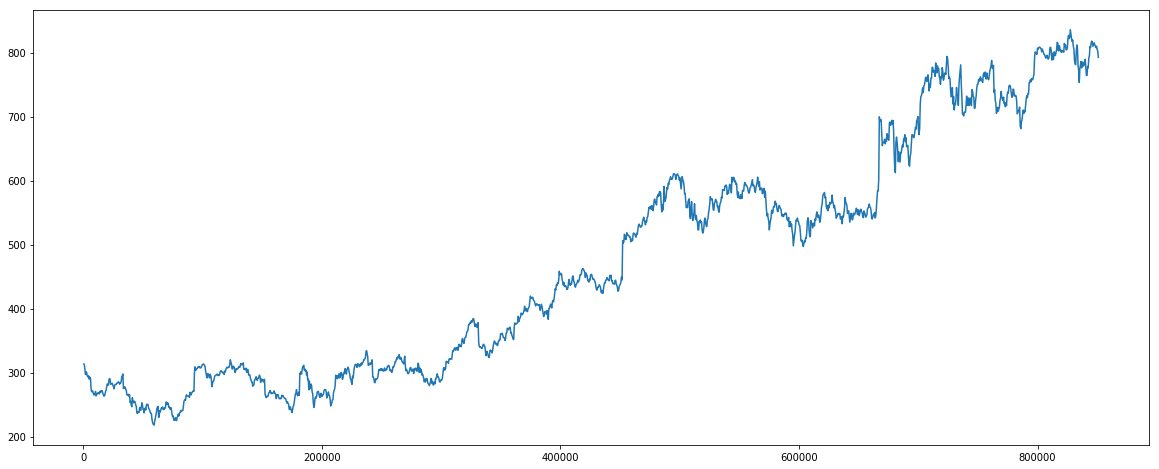

In [13]:
plt.figure(figsize=(20,8))
plt.plot(df["GOOGL"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 128.96127532590685
Moving average r-squared score is : -11.414389749257687


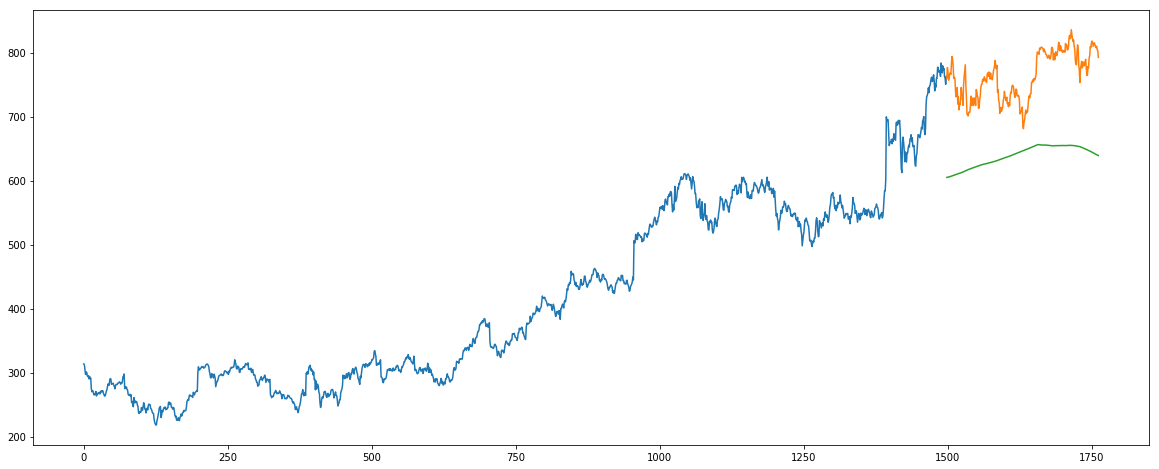

In [14]:
moving_average(df['GOOGL'],0.85)

Linear Regression RMS score is :90.44388785948705
Linear Regression r-squared score is : -5.106117862834632


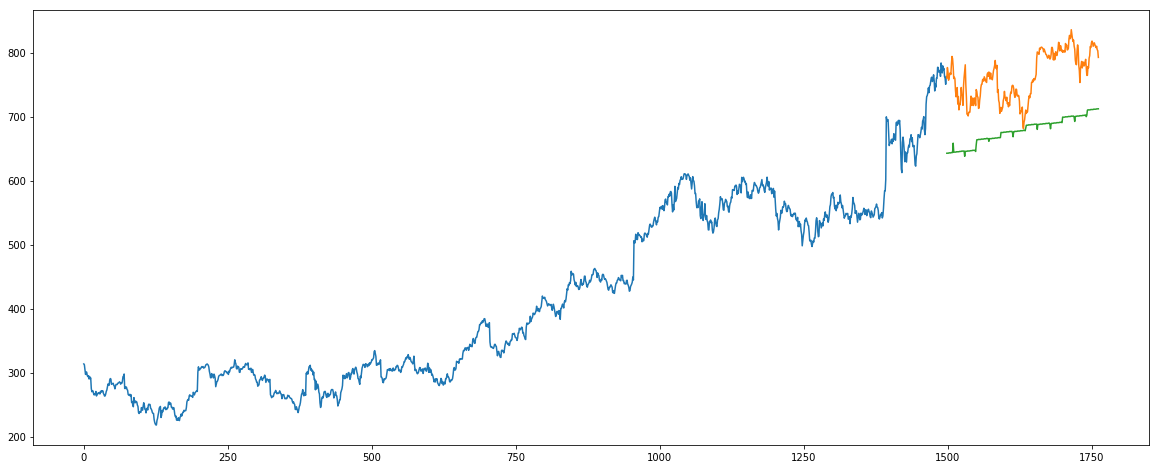

In [15]:
linear_regression(df['GOOGL'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 195.0829951312544
Linear Regression r-squared score is : -27.40832100941261


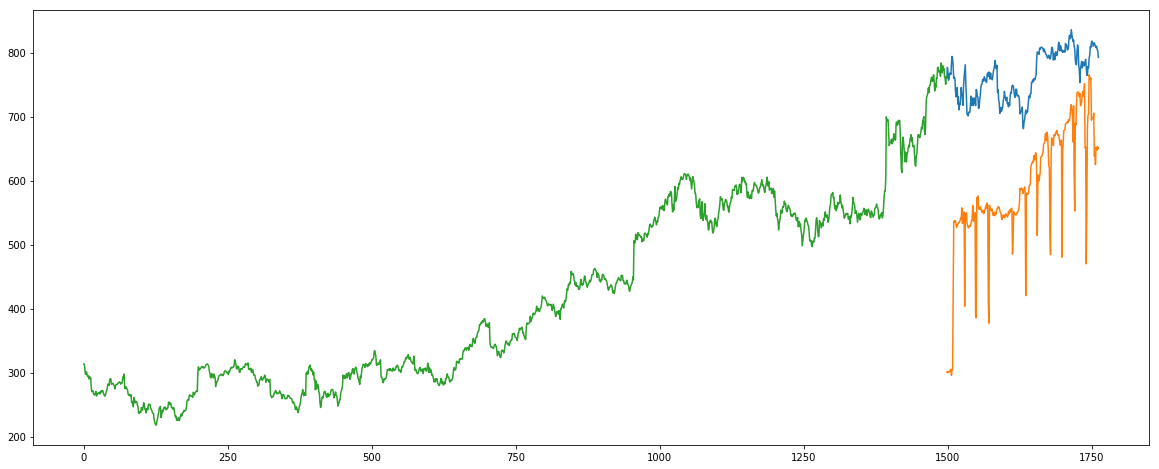

In [16]:
KNN(df['GOOGL'],0.85)

Prophet RMS is : 36.40281159106537
R-squared score is : 0.010817115903552499


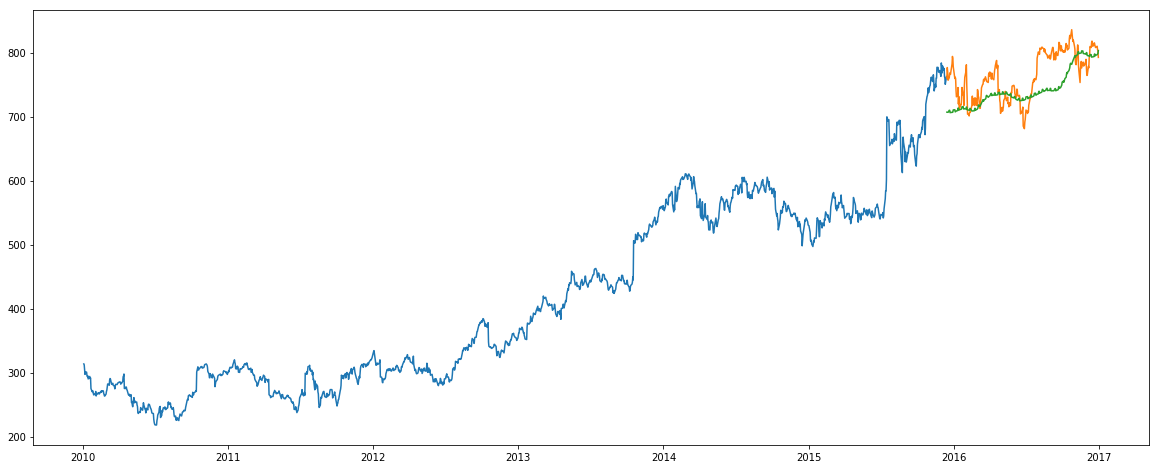

In [17]:
fbprophet(df['GOOGL'],0.85)

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10028.317, BIC=10054.832, Fit time=18.074 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=11037.151, BIC=11047.758, Fit time=0.367 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=10598.964, BIC=10620.177, Fit time=9.896 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10026.367, BIC=10047.580, Fit time=17.191 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=10026.241, BIC=10052.757, Fit time=22.665 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=10598.894, BIC=10620.106, Fit time=11.582 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=10030.333, BIC=10062.152, Fit time=60.722 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=11034.801, BIC=11050.711, Fit time=1.041 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=10026.897, BIC=10064.019, Fit time=108.631 seconds
Fit

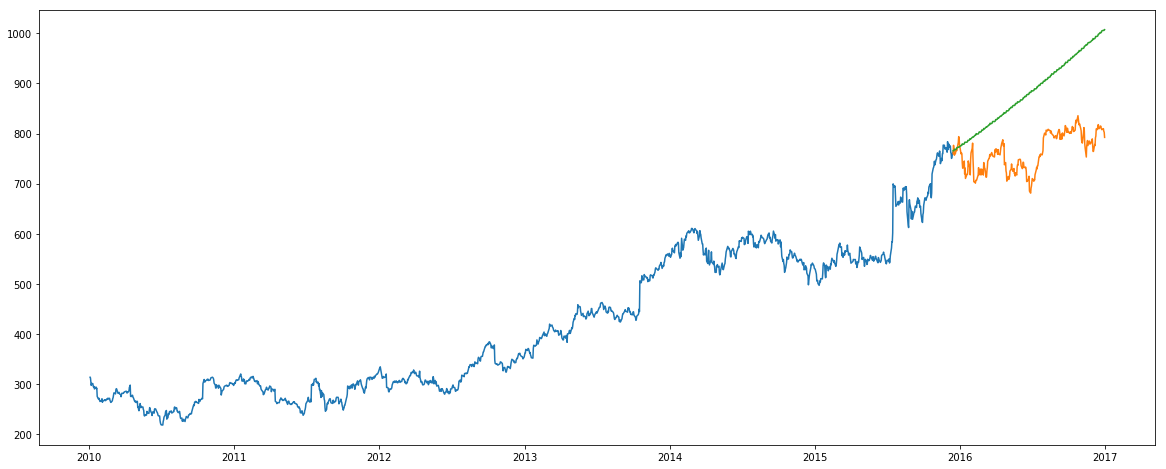

In [18]:
ARIMA(df['GOOGL'],0.85)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 136s - loss: 0.0015
LSTM 35.45882948337665
LSTM r-squared score is : 0.06145407659907787


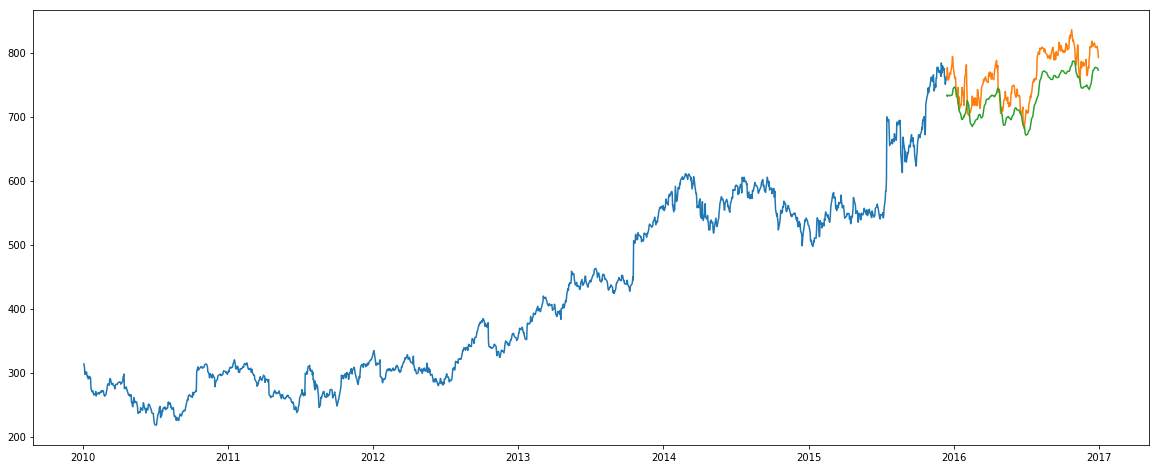

In [19]:
LSTM(df['GOOGL'],0.85)

# Google Class C stock (Ticker 'GOOG')


In [20]:
df['GOOGL'].head()

Date        Open       Close         Low        High  \
Date                                                                    
2010-01-04 2010-01-04  313.788792  313.688694  312.432438  315.070073   
2010-01-05 2010-01-05  313.903904  312.307316  311.081089  314.234226   
2010-01-06 2010-01-06  313.243260  304.434452  303.483494  313.243260   
2010-01-07 2010-01-07  305.005009  297.347355  296.621617  305.305302   
2010-01-08 2010-01-08  296.296299  301.311314  294.849857  301.926945   

                Volume  
Date                    
2010-01-04   3908400.0  
2010-01-05   6003300.0  
2010-01-06   7949400.0  
2010-01-07  12815700.0  
2010-01-08   9439100.0

# Plots and models fitting

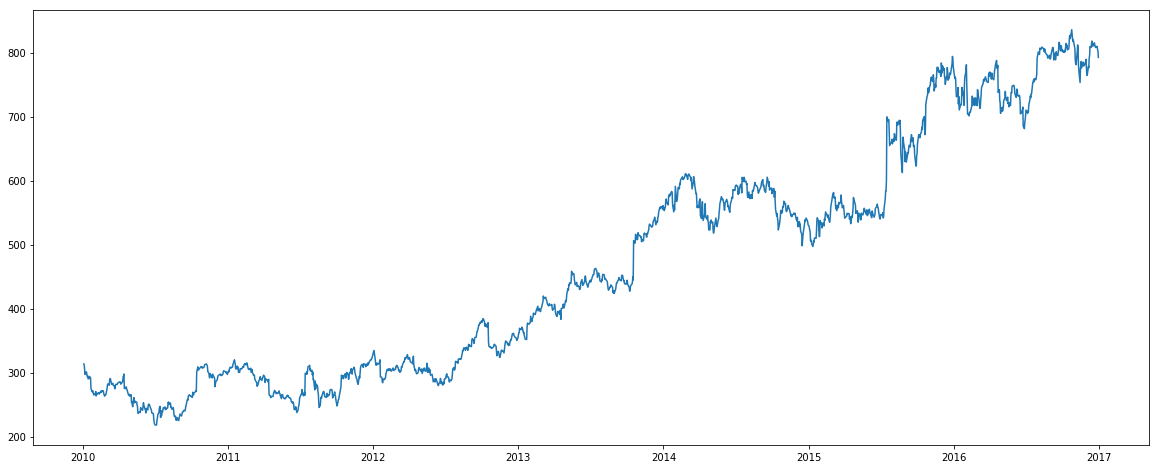

In [21]:
plt.figure(figsize=(20,8))
plt.plot(df["GOOGL"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 129.5594065381437
Moving average r-squared score is : -13.733598463490566


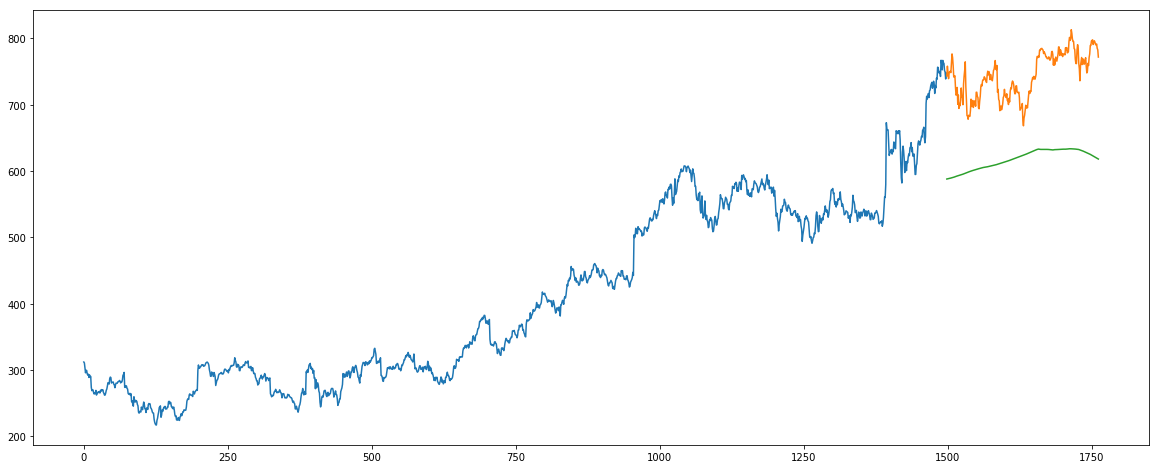

In [22]:
moving_average(df['GOOG'],0.85)

Linear Regression RMS score is :85.08644729319862
Linear Regression r-squared score is : -5.354651099558478


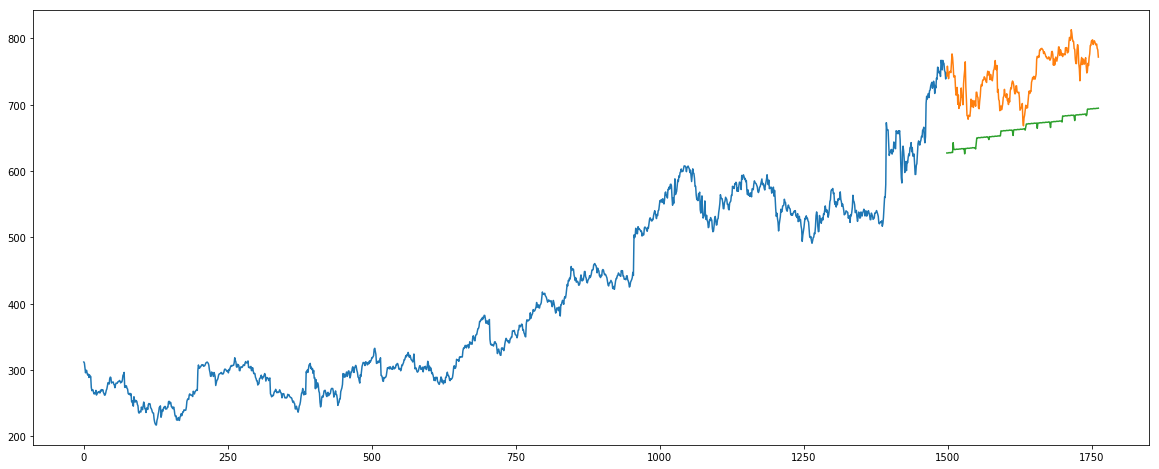

In [23]:
linear_regression(df['GOOG'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 189.49189868935284
Linear Regression r-squared score is : -30.517533605616673


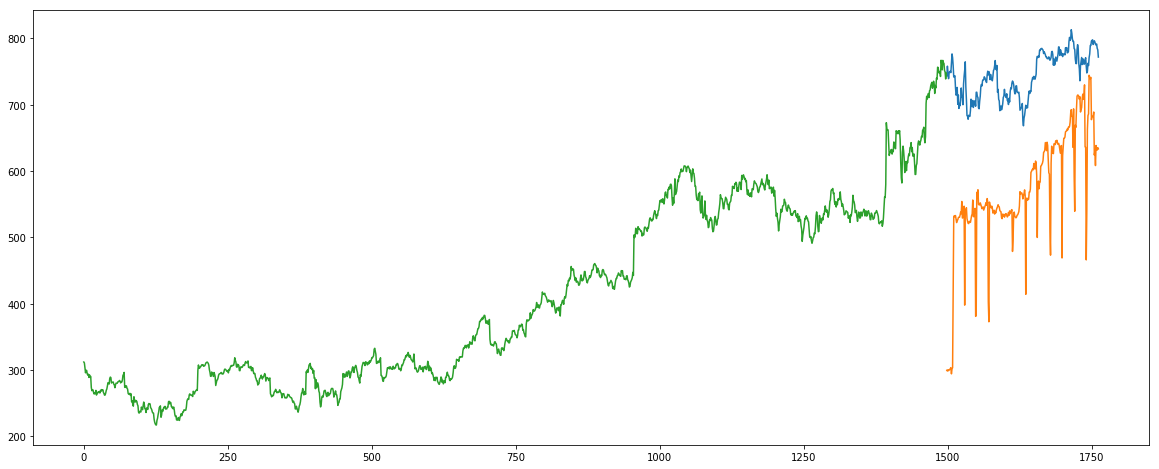

In [24]:
KNN(df['GOOG'],0.85)

Prophet RMS is : 45.43508346403444
R-squared score is : -0.8119807943245567


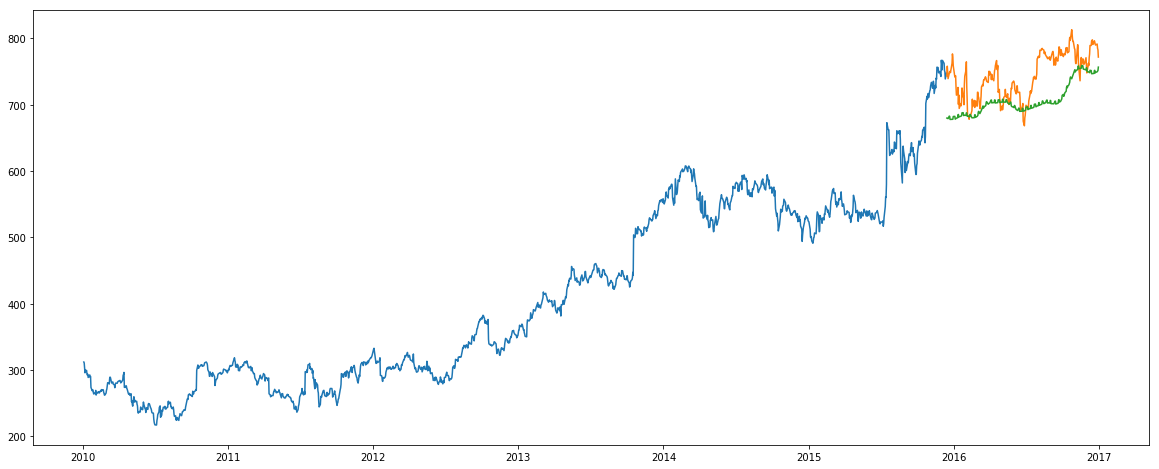

In [25]:
fbprophet(df['GOOG'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10002.077, BIC=10028.593, Fit time=24.425 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=11005.282, BIC=11015.888, Fit time=0.372 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=10567.080, BIC=10588.293, Fit time=11.442 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10000.340, BIC=10021.553, Fit time=19.134 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=10000.518, BIC=10027.034, Fit time=20.977 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=11003.653, BIC=11019.563, Fit time=1.544 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=10000.443, BIC=10026.959, Fit time=47.048 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=10004.341, BIC=10036.160, Fit time=62.198 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=10000.620, BIC=10016.530, Fit time=11.284 seconds
Fit

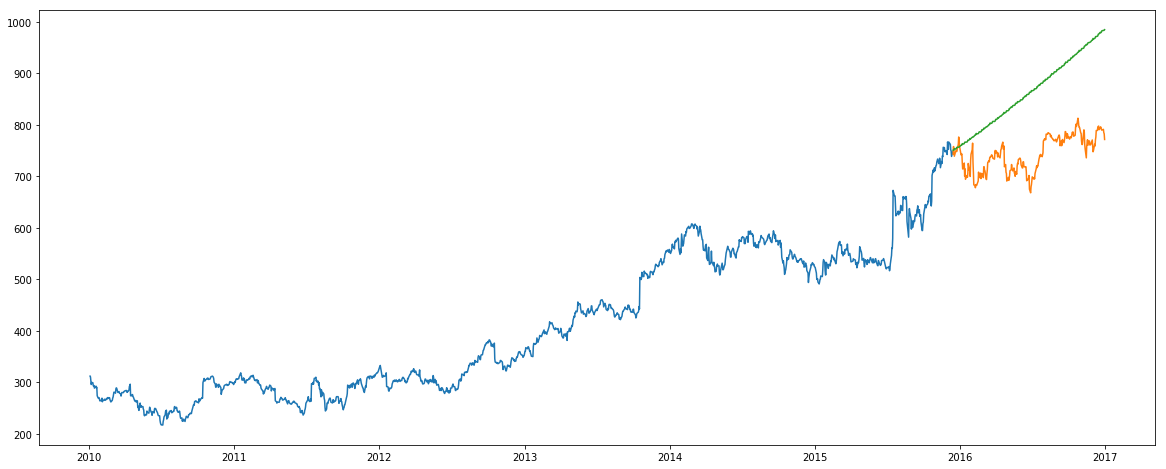

In [26]:
ARIMA(df['GOOG'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 171s - loss: 0.0021
LSTM 18.6969449093871
LSTM r-squared score is : 0.69315982161039


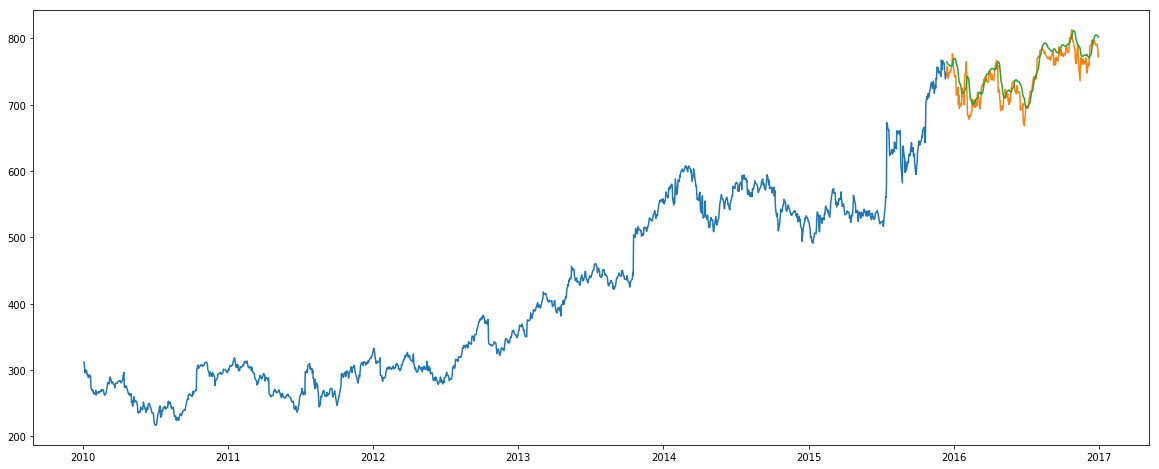

In [27]:
LSTM(df['GOOG'],0.85)

# APPLE INC (Ticker 'AAPL')

In [28]:
df['AAPL'].head()

Date       Open      Close        Low       High       Volume
254   2010-01-04  30.490000  30.572857  30.340000  30.642857  123432400.0
721   2010-01-05  30.657143  30.625713  30.464285  30.798571  150476200.0
1189  2010-01-06  30.625713  30.138571  30.107143  30.747143  138040000.0
1657  2010-01-07  30.250000  30.082857  29.864286  30.285715  119282800.0
2125  2010-01-08  30.042856  30.282858  29.865715  30.285715  111902700.0

# Plots and models fitting

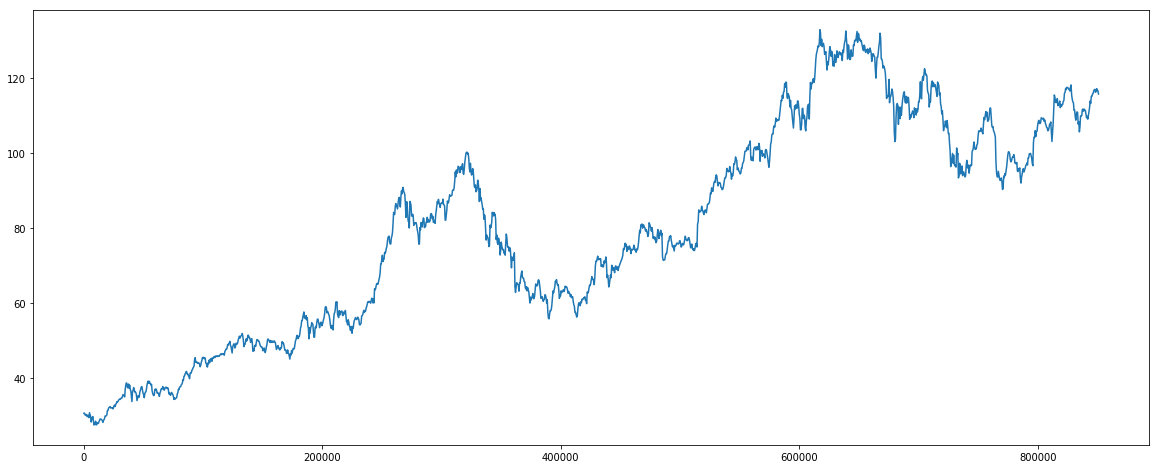

In [29]:
plt.figure(figsize=(20,8))
plt.plot(df["AAPL"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 16.947225637386364
Moving average r-squared score is : -4.116121663688705


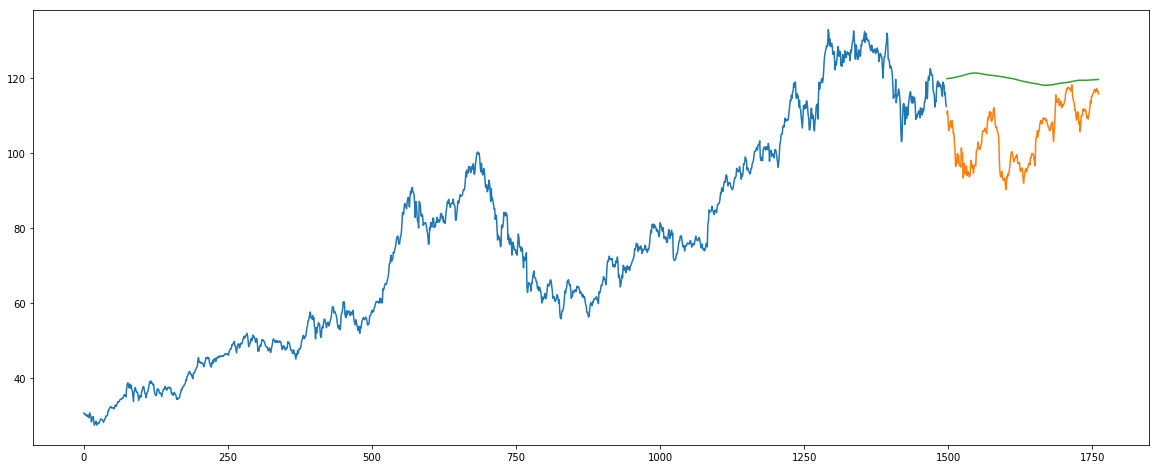

In [30]:
moving_average(df['AAPL'],0.85)

Linear Regression RMS score is :26.13215058403983
Linear Regression r-squared score is : -11.164491082741847


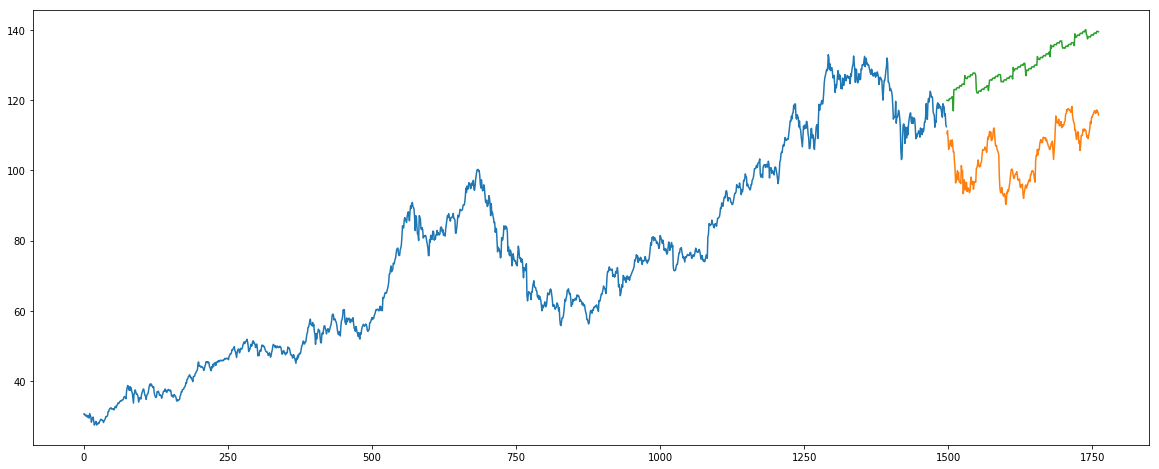

In [31]:
linear_regression(df['AAPL'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 24.48761701892274
Linear Regression r-squared score is : -9.681609302907033


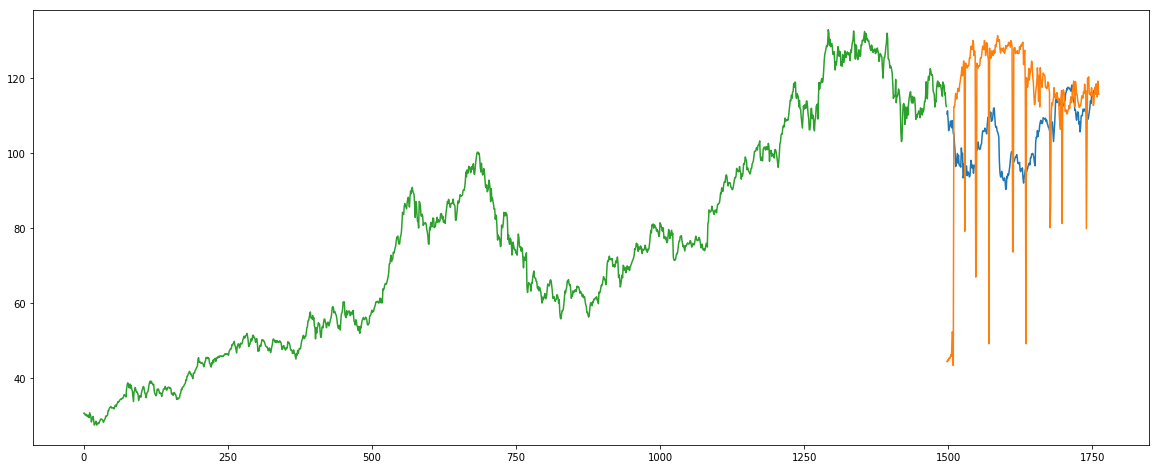

In [32]:
KNN(df['AAPL'],0.85)

Prophet RMS is : 25.625744549162196
R-squared score is : -10.697596194578011


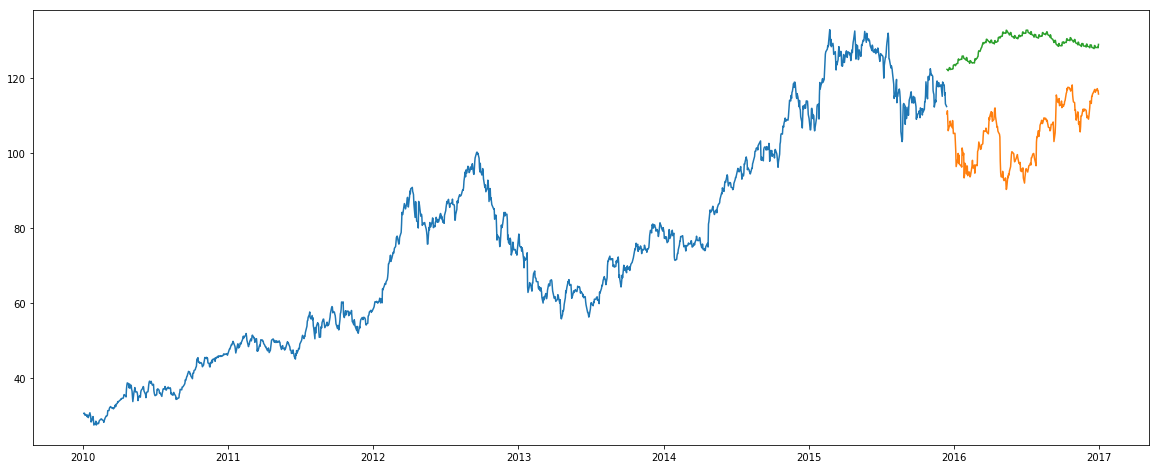

In [33]:
fbprophet(df['AAPL'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5076.238, BIC=5102.754, Fit time=50.559 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6053.372, BIC=6063.978, Fit time=1.134 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5602.405, BIC=5623.617, Fit time=7.556 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5074.489, BIC=5095.701, Fit time=32.302 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5076.410, BIC=5102.926, Fit time=54.481 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=6054.512, BIC=6070.421, Fit time=2.433 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=5076.414, BIC=5102.930, Fit time=107.409 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5071.681, BIC=5103.500, Fit time=100.785 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5073.494, BIC=5110.616, Fit time=178.137 seconds
Fit ARIMA: order=(0

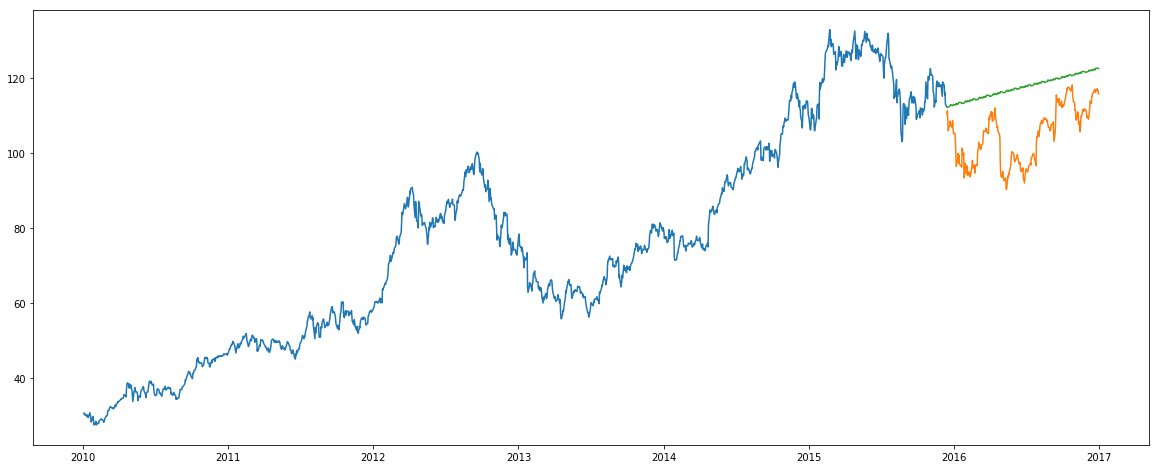

In [34]:
ARIMA(df['AAPL'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 153s - loss: 0.0029
LSTM 3.1595215447269163
LSTM r-squared score is : 0.8221776757387544


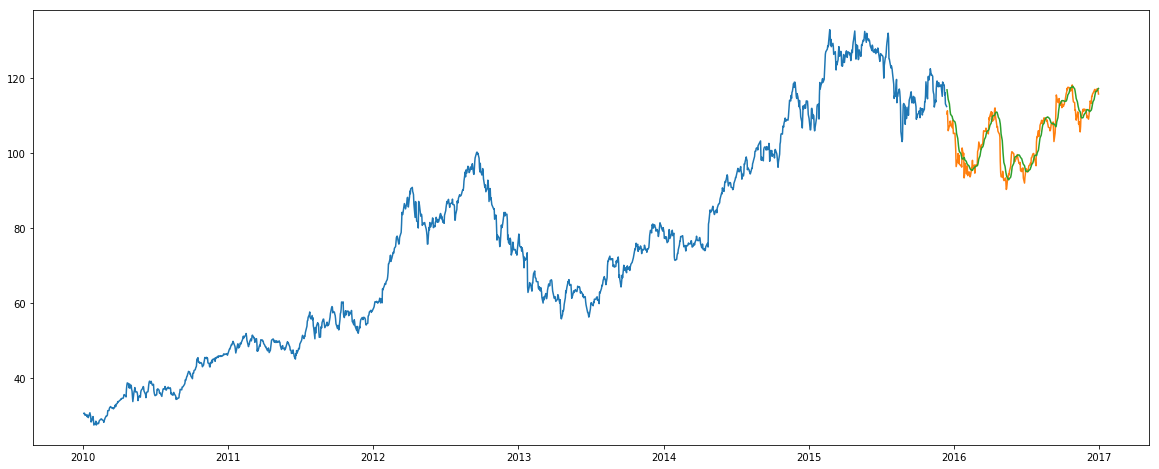

In [35]:
LSTM(df['AAPL'],0.85)

# ADOBE INC (Ticker ADBE)

In [36]:
df['ADBE'].head()

Date       Open      Close        Low       High     Volume
258   2010-01-04  36.650002  37.090000  36.650002  37.299999  4710200.0
725   2010-01-05  37.040001  37.700001  36.869999  37.799999  7108800.0
1193  2010-01-06  37.330002  37.619999  37.200001  37.740002  5336400.0
1661  2010-01-07  37.410000  36.889999  36.810001  37.590000  5576700.0
2129  2010-01-08  36.750000  36.689999  36.340000  36.970001  5429200.0

# Plots and models fitting

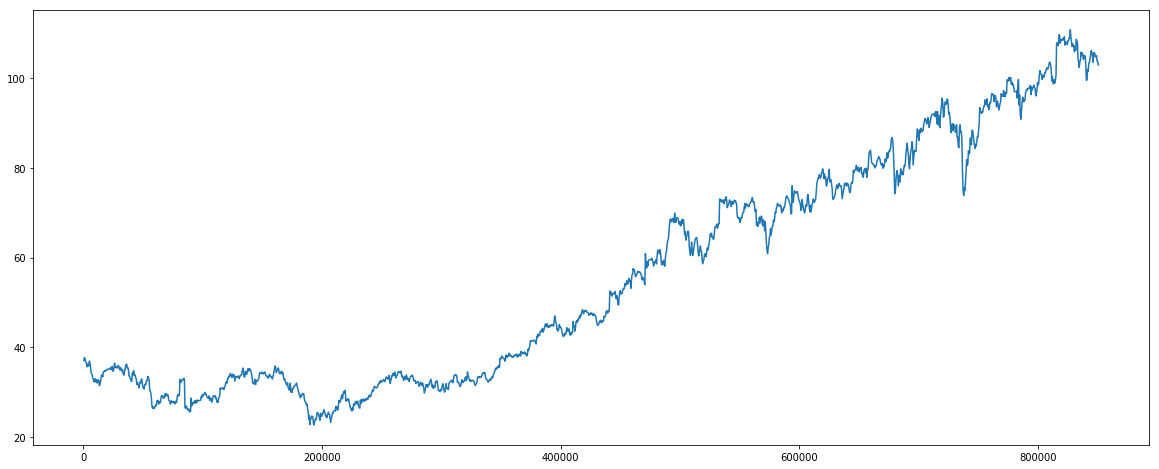

In [37]:
plt.figure(figsize=(20,8))
plt.plot(df["ADBE"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 16.499443888016085
Moving average r-squared score is : -3.6926995665777405


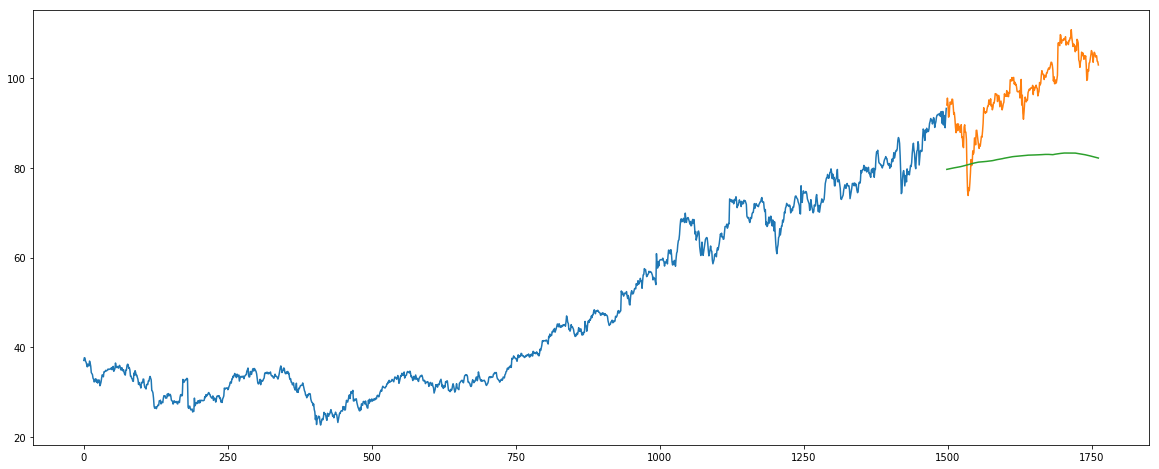

In [38]:
moving_average(df['ADBE'],0.85)

Linear Regression RMS score is :16.10134907784432
Linear Regression r-squared score is : -3.468982653913371


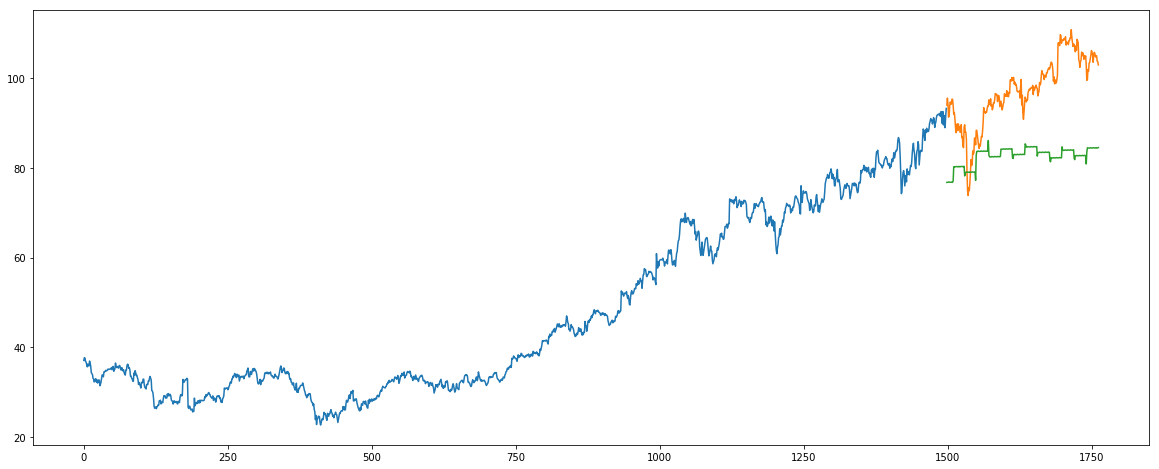

In [39]:
linear_regression(df['ADBE'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 26.459196338000353
Linear Regression r-squared score is : -11.068059302016621


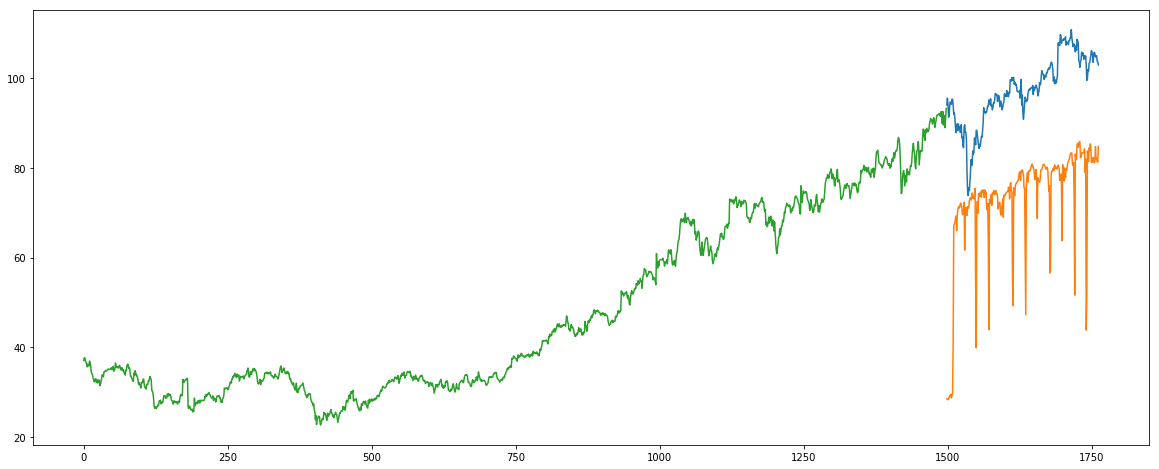

In [40]:
KNN(df['ADBE'],0.85)

Prophet RMS is : 5.649747485172165
R-squared score is : 0.44977260085405024


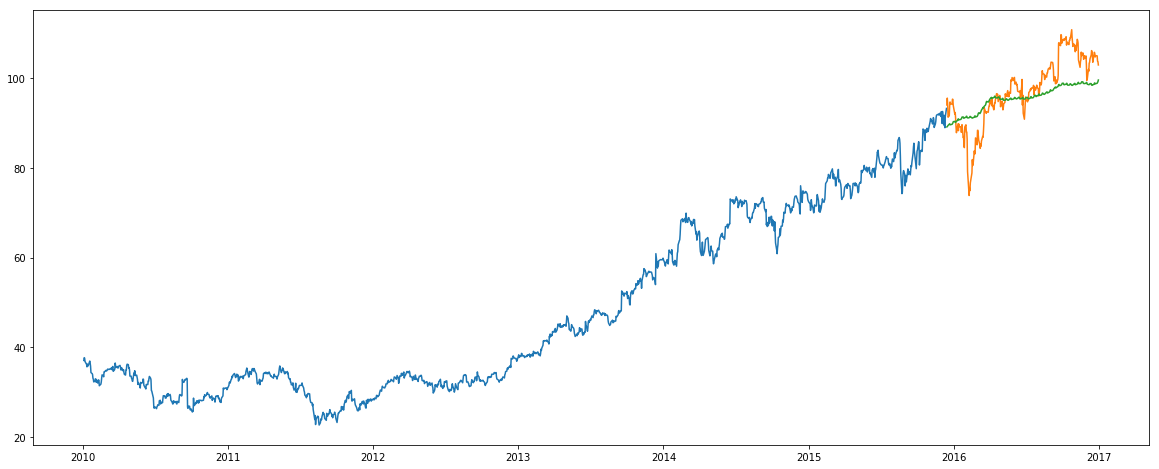

In [41]:
fbprophet(df['ADBE'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3787.057, BIC=3813.572, Fit time=68.341 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4809.406, BIC=4820.013, Fit time=2.334 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4311.618, BIC=4332.831, Fit time=16.164 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3788.338, BIC=3809.550, Fit time=35.420 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3779.478, BIC=3811.297, Fit time=64.802 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4264.328, BIC=4290.844, Fit time=61.258 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3781.061, BIC=3818.184, Fit time=163.629 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4730.124, BIC=4751.337, Fit time=18.782 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3783.245, BIC=3825.671, Fit time=183.937 seconds
Fit ARIMA: order=(

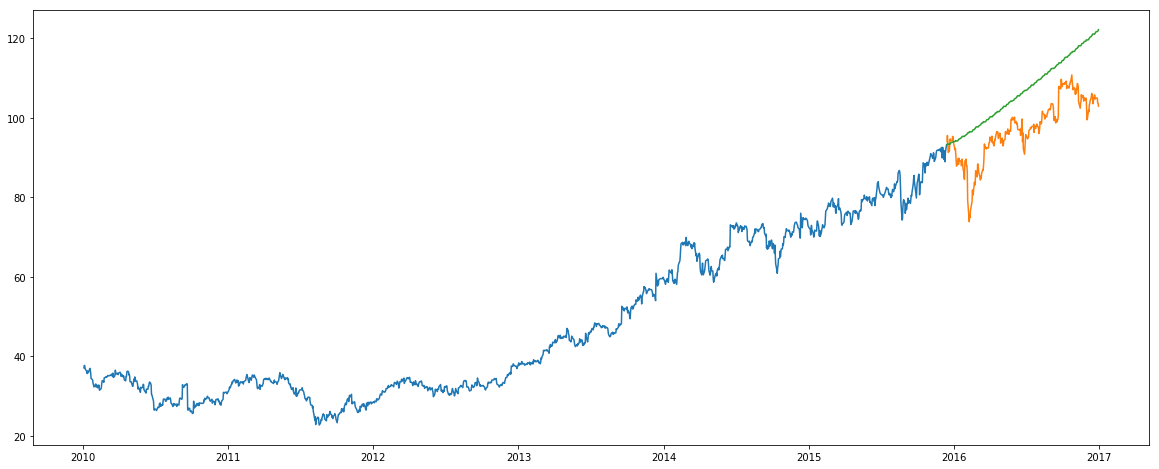

In [42]:
ARIMA(df['ADBE'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 279s - loss: 0.0010
LSTM 6.500577985069542
LSTM r-squared score is : 0.27156956474733907


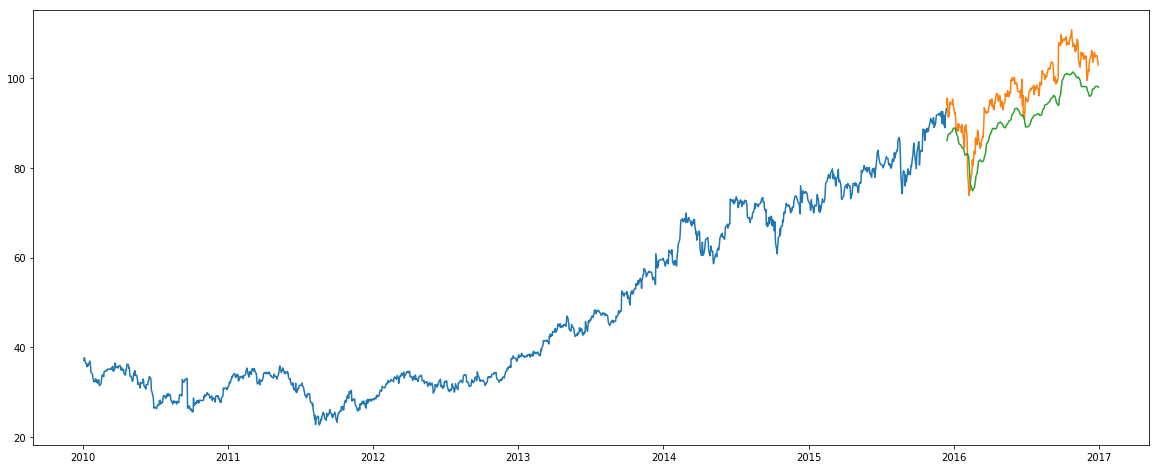

In [43]:
LSTM(df['ADBE'],0.85)

# amazon.com (Ticker AMZN)

In [44]:
df['AMZN'].head()

Date        Open       Close         Low        High      Volume
284   2010-01-04  136.250000  133.899994  133.139999  136.610001   7599900.0
751   2010-01-05  133.429993  134.690002  131.809998  135.479996   8851900.0
1219  2010-01-06  134.600006  132.250000  131.649994  134.729996   7178800.0
1687  2010-01-07  132.009995  130.000000  128.800003  132.320007  11030200.0
2155  2010-01-08  130.559998  133.520004  129.029999  133.679993   9830500.0

# Plots and models fitting

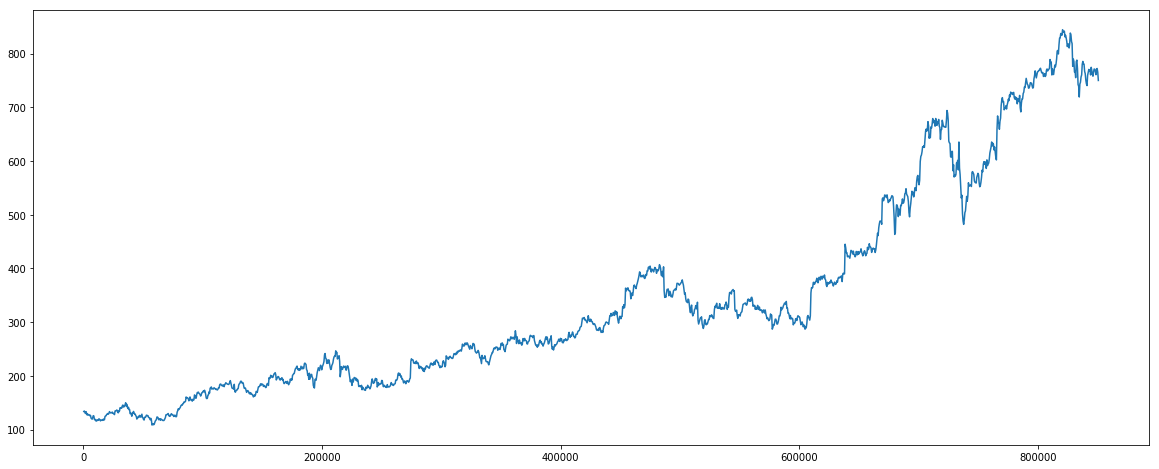

In [45]:
plt.figure(figsize=(20,8))
plt.plot(df["AMZN"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 207.67336728733315
Moving average r-squared score is : -4.291823365913384


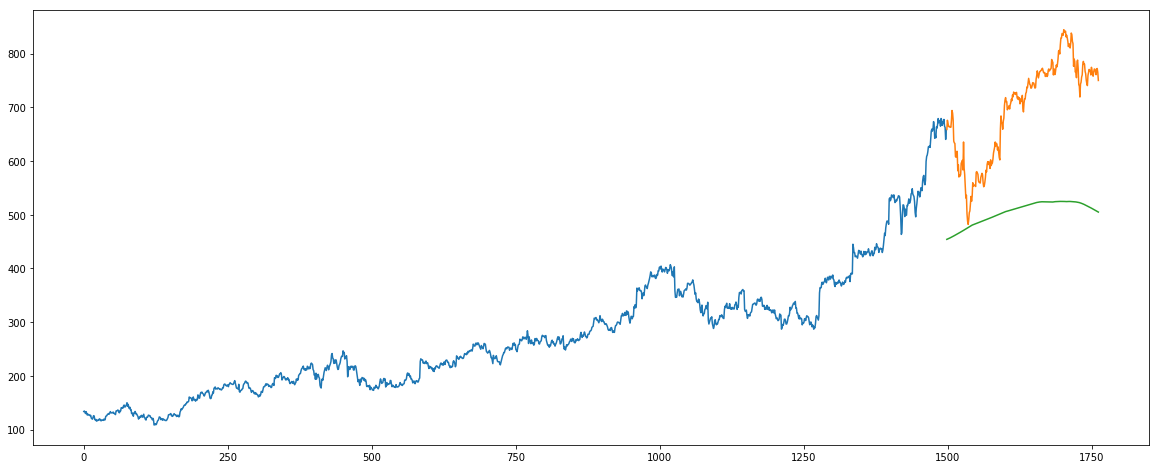

In [46]:
moving_average(df['AMZN'],0.85)

Linear Regression RMS score is :221.85674424496432
Linear Regression r-squared score is : -5.039333337318464


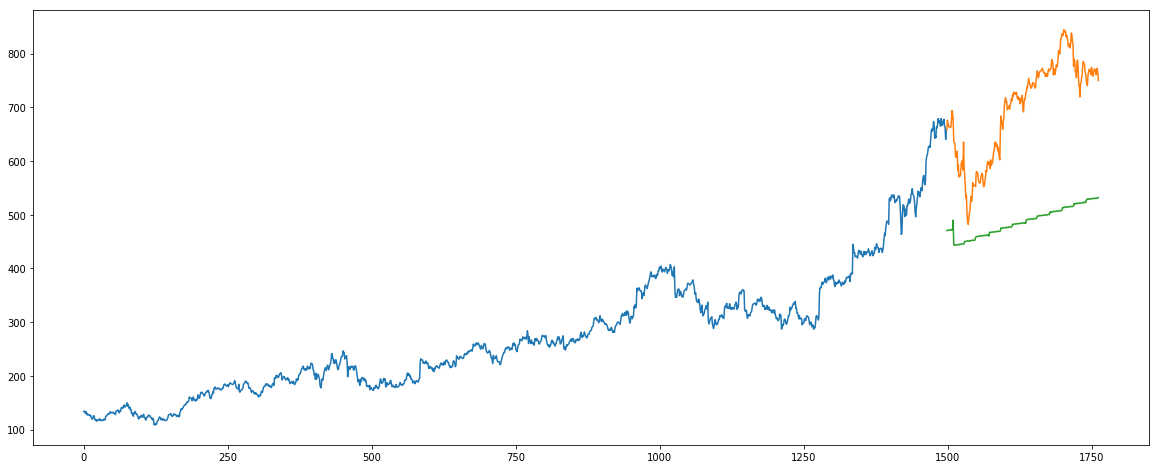

In [47]:
linear_regression(df['AMZN'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 280.69419400981593
Linear Regression r-squared score is : -8.667420053376238


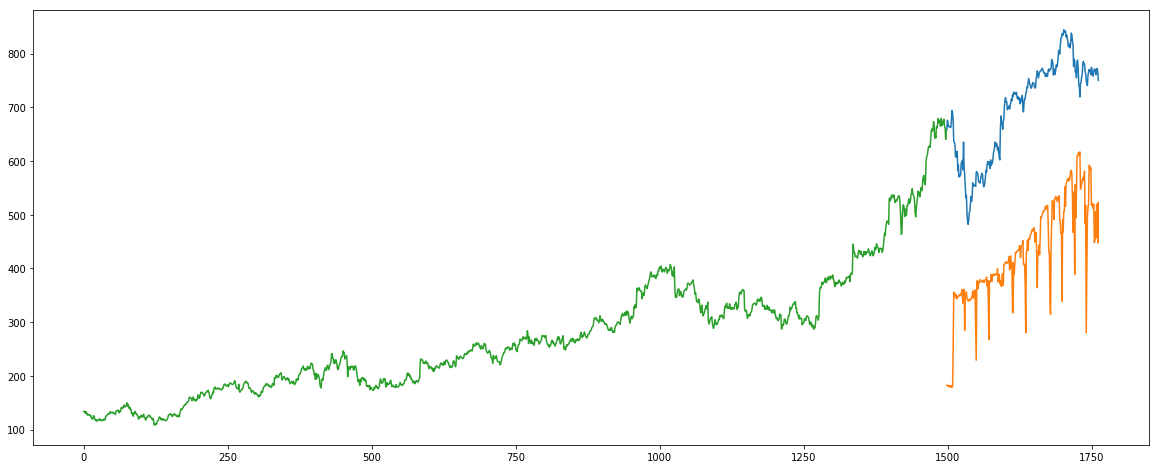

In [48]:
KNN(df['AMZN'],0.85)

Prophet RMS is : 53.608695748082525
R-squared score is : 0.6473740958059735


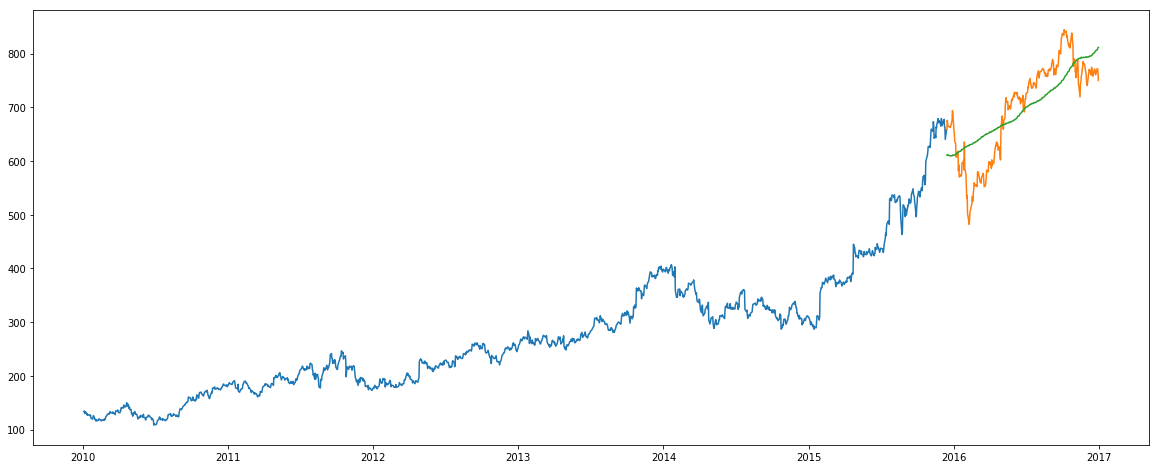

In [49]:
fbprophet(df['AMZN'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=9585.782, BIC=9612.297, Fit time=54.068 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=10624.430, BIC=10635.036, Fit time=0.893 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=10118.170, BIC=10139.383, Fit time=12.475 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=9585.010, BIC=9606.223, Fit time=35.445 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=9582.502, BIC=9609.018, Fit time=38.727 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=10118.170, BIC=10139.383, Fit time=10.227 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=9584.672, BIC=9616.491, Fit time=119.903 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=10623.420, BIC=10639.329, Fit time=1.603 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=9585.511, BIC=9622.633, Fit time=84.905 seconds
Fit ARIMA: o

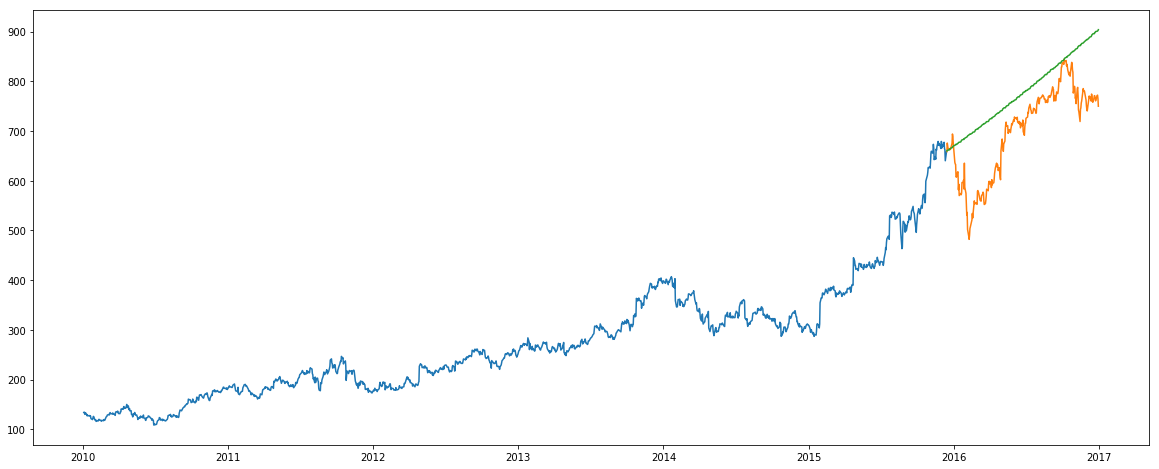

In [50]:
ARIMA(df['AMZN'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 156s - loss: 9.4992e-04
LSTM 28.762210110152427
LSTM r-squared score is : 0.8984948121918763


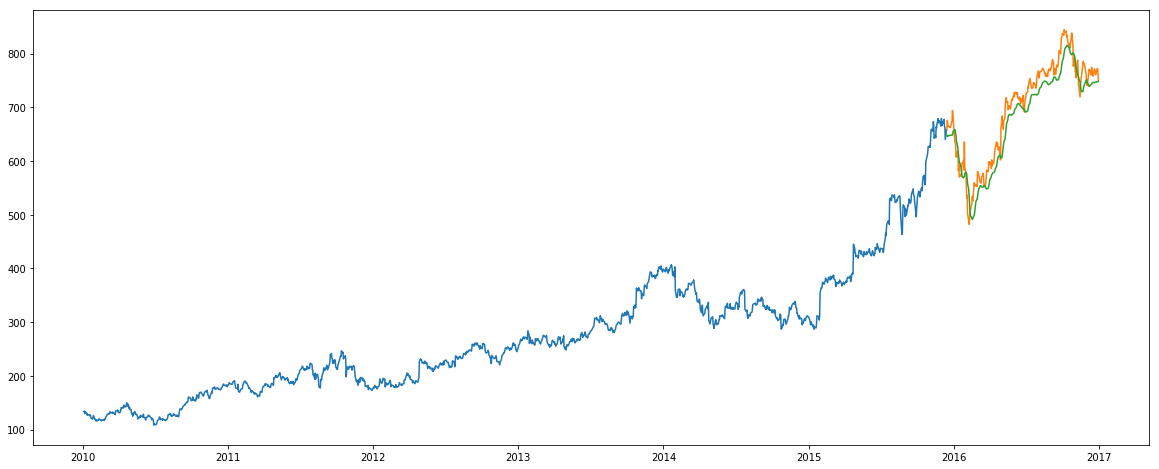

In [51]:
LSTM(df['AMZN'],0.85)

# Seagate Technology (Ticker STX)

In [52]:
df['STX'].head()

Date       Open      Close        Low       High      Volume
640   2010-01-04  18.570000  18.889999  18.400000  18.969999  11116900.0
1108  2010-01-05  18.860001  18.520000  18.430000  19.040001  14536200.0
1576  2010-01-06  18.430000  18.389999  18.219999  18.639999   7171200.0
2044  2010-01-07  18.400000  18.040001  17.940001  18.410000   8556300.0
2512  2010-01-08  17.580000  17.889999  17.480000  18.080000  11329000.0

# Plots and models fitting

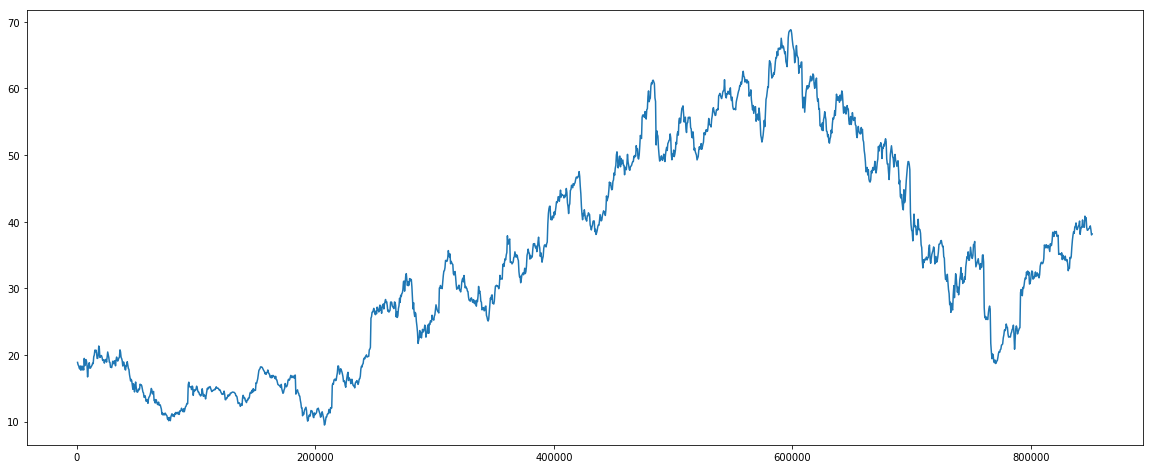

In [53]:
plt.figure(figsize=(20,8))
plt.plot(df["STX"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 17.522889939455112
Moving average r-squared score is : -8.241852886039192


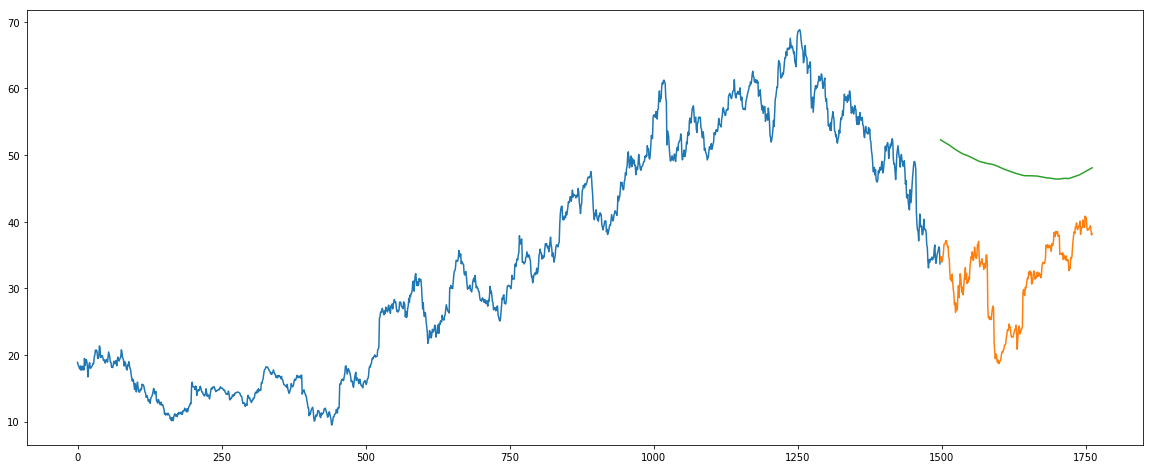

In [54]:
moving_average(df['STX'],0.85)

Linear Regression RMS score is :34.779012060746
Linear Regression r-squared score is : -35.40676303484449


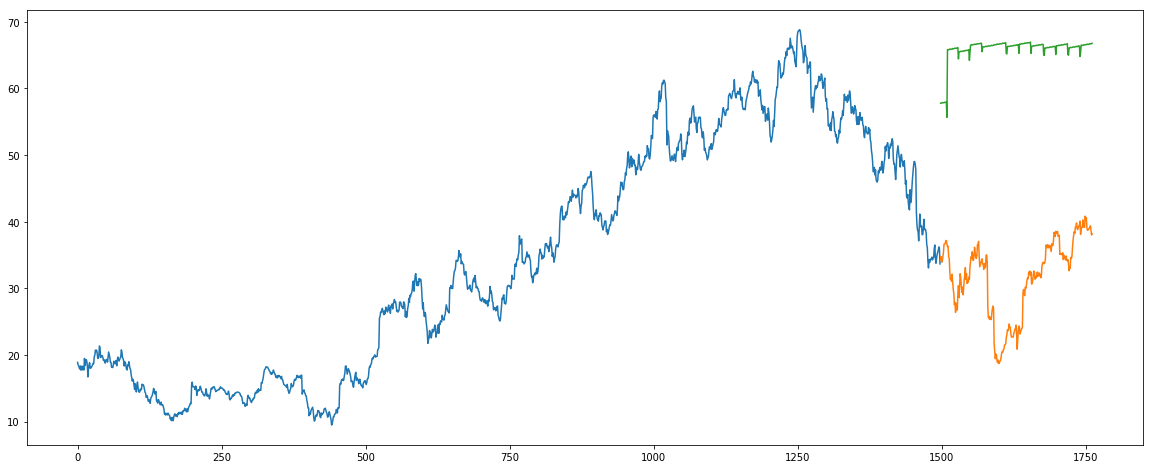

In [55]:
linear_regression(df['STX'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 22.484138690131886
Linear Regression r-squared score is : -14.215985848984342


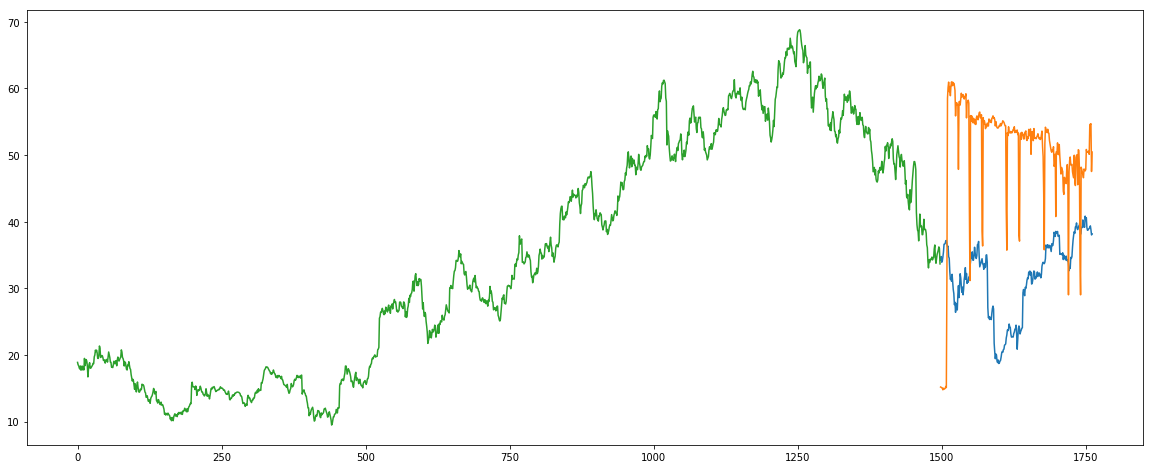

In [56]:
KNN(df['STX'],0.85)

Prophet RMS is : 9.91002618466462
R-squared score is : -1.9559507145846493


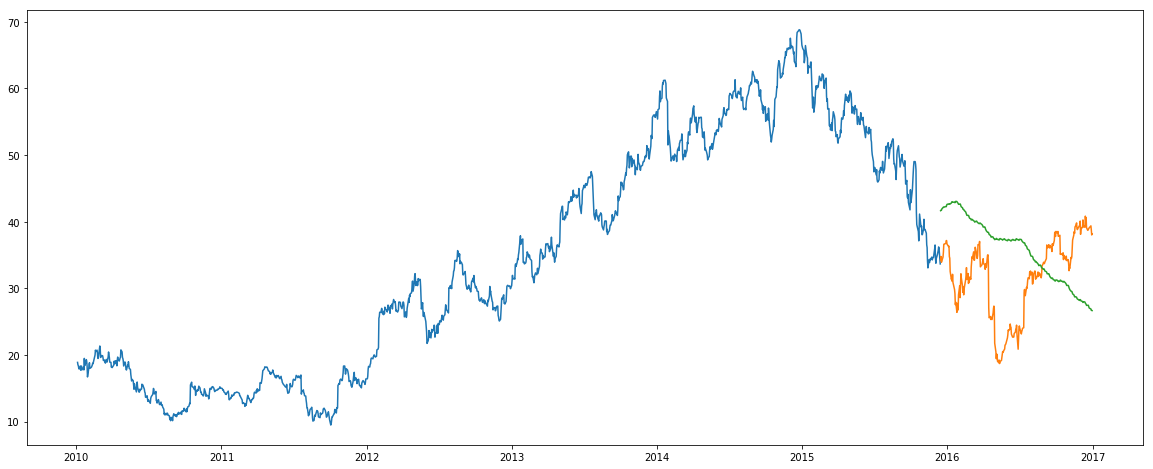

In [57]:
fbprophet(df['STX'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3625.310, BIC=3651.826, Fit time=38.949 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4685.441, BIC=4696.047, Fit time=0.679 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4231.114, BIC=4252.327, Fit time=9.898 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3624.751, BIC=3645.964, Fit time=40.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3620.884, BIC=3647.400, Fit time=43.667 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4231.671, BIC=4252.884, Fit time=10.647 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3625.877, BIC=3657.696, Fit time=150.610 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4681.930, BIC=4697.839, Fit time=7.956 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3624.568, BIC=3661.691, Fit time=145.784 seconds
Fit ARIMA: order=(1,

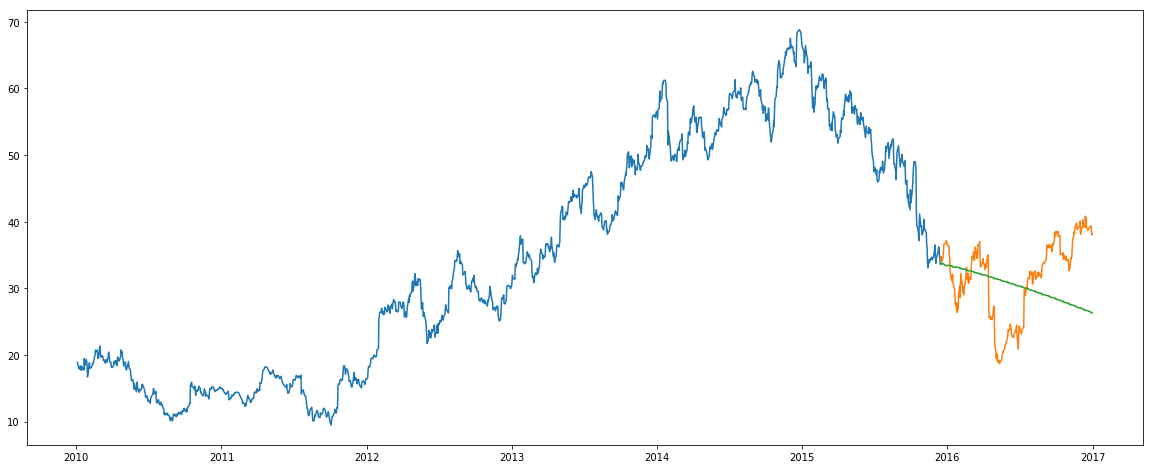

In [58]:
ARIMA(df['STX'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 280s - loss: 0.0033
LSTM 1.8901194819488558
LSTM r-squared score is : 0.892470877503726


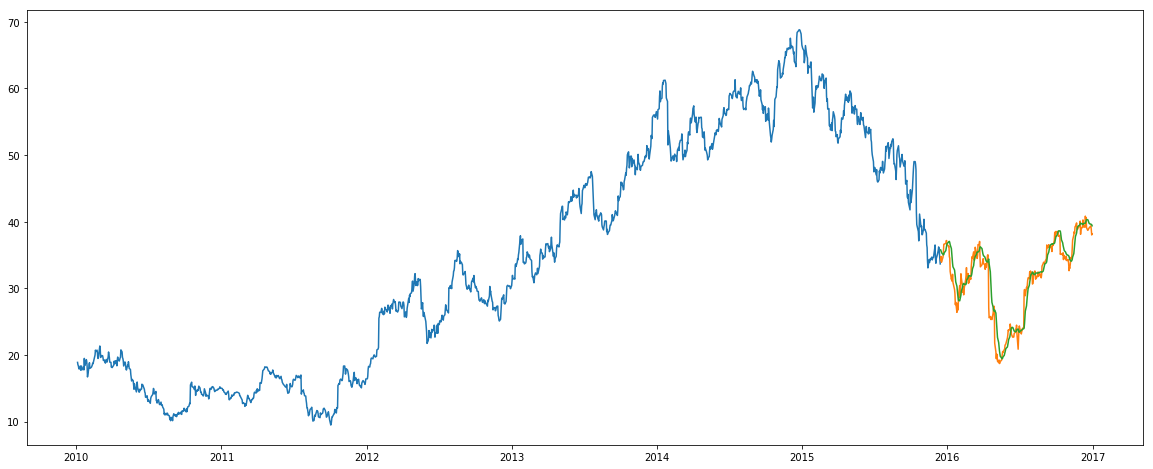

In [59]:
LSTM(df['STX'],0.85)

# Netflix (Ticker NFLX)

In [60]:
df['NFLX'].head()

Date      Open     Close       Low      High      Volume
555   2010-01-04  7.931428  7.640000  7.565714  7.961429  17239600.0
1023  2010-01-05  7.652857  7.358572  7.258572  7.657143  23753100.0
1491  2010-01-06  7.361429  7.617143  7.197143  7.672857  23290400.0
1959  2010-01-07  7.731429  7.485714  7.462857  7.757143   9955400.0
2427  2010-01-08  7.498571  7.614286  7.465714  7.742857   8180900.0

# Plots and models fitting

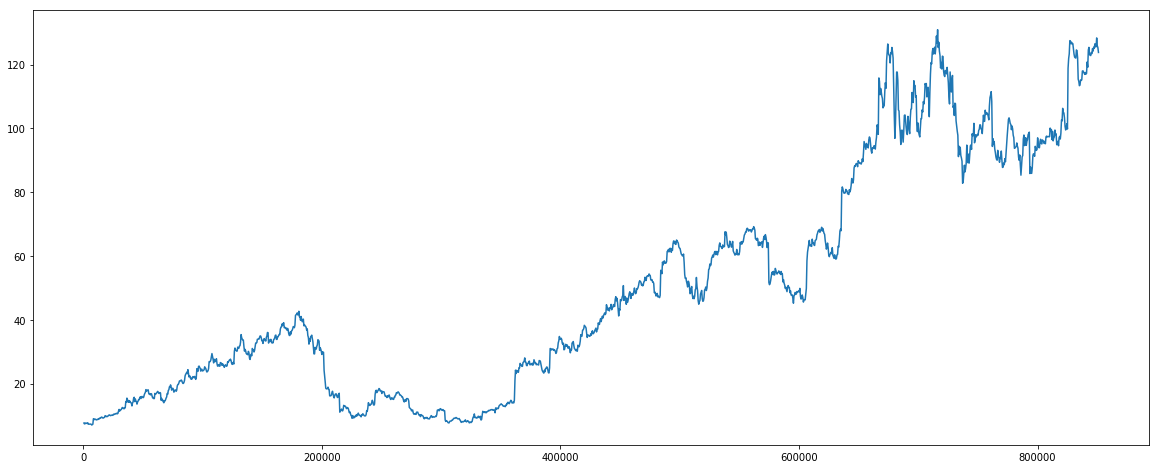

In [61]:
plt.figure(figsize=(20,8))
plt.plot(df["NFLX"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 14.06052790137205
Moving average r-squared score is : -0.380499989711246


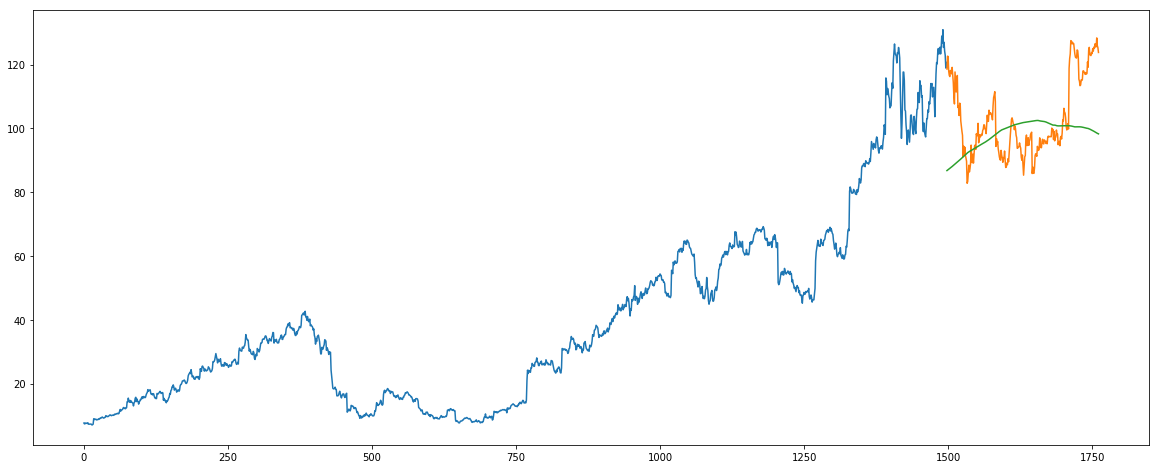

In [62]:
moving_average(df['NFLX'],0.85)

Linear Regression RMS score is :23.607920537355504
Linear Regression r-squared score is : -2.891783066080846


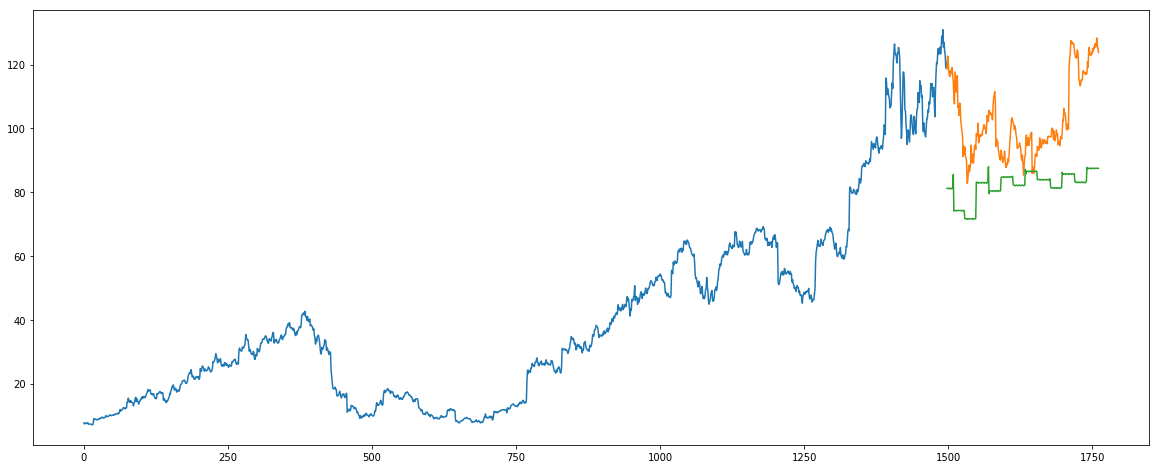

In [63]:
linear_regression(df['NFLX'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 36.70591624106339
Linear Regression r-squared score is : -8.408172966364646


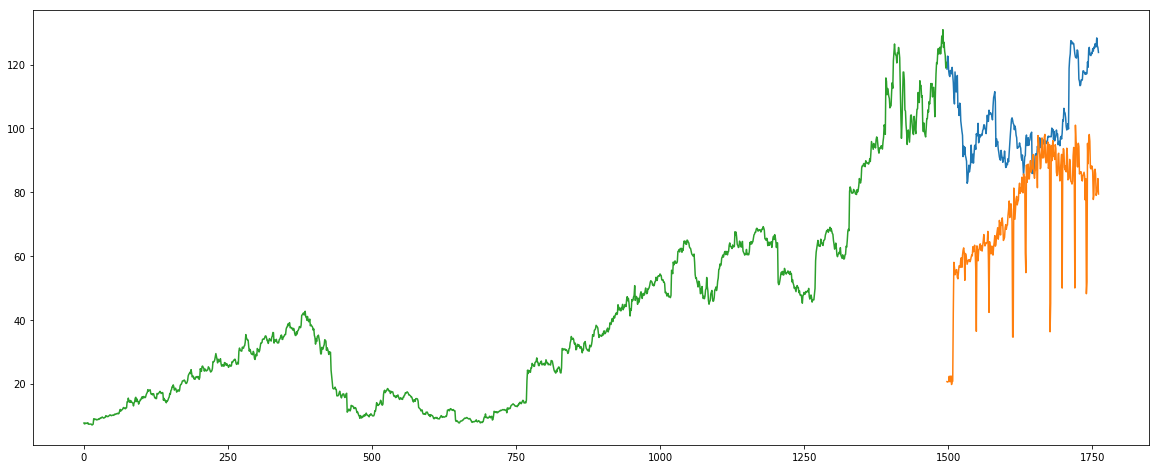

In [64]:
KNN(df['NFLX'],0.85)

Prophet RMS is : 38.664346364607624
R-squared score is : -9.438894296779491


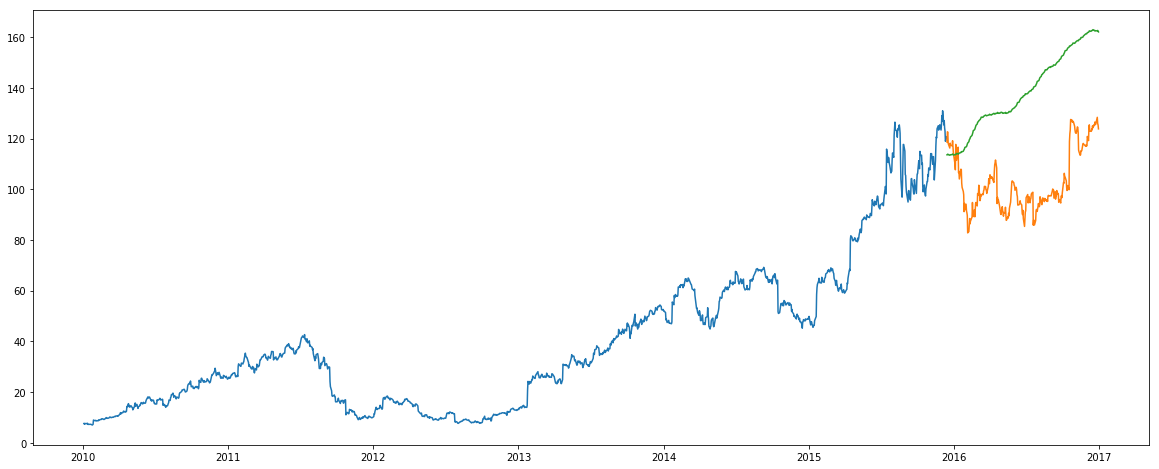

In [65]:
fbprophet(df['NFLX'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5496.919, BIC=5523.435, Fit time=47.514 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=6525.116, BIC=6535.722, Fit time=5.935 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=6044.924, BIC=6066.136, Fit time=23.734 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5494.939, BIC=5516.152, Fit time=33.820 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5494.111, BIC=5520.627, Fit time=47.030 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=6046.669, BIC=6067.881, Fit time=23.616 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=5495.787, BIC=5527.607, Fit time=154.486 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=6510.728, BIC=6526.637, Fit time=7.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=5497.787, BIC=5534.909, Fit time=112.296 seconds
Fit ARIMA: order=(1

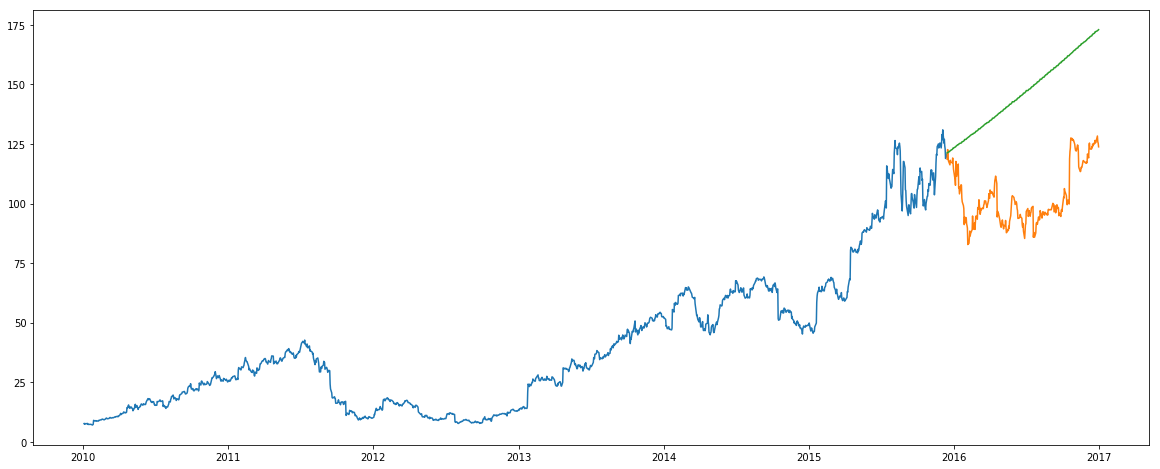

In [66]:
ARIMA(df['NFLX'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 149s - loss: 0.0022
LSTM 7.197860963528156
LSTM r-squared score is : 0.6382237427395656


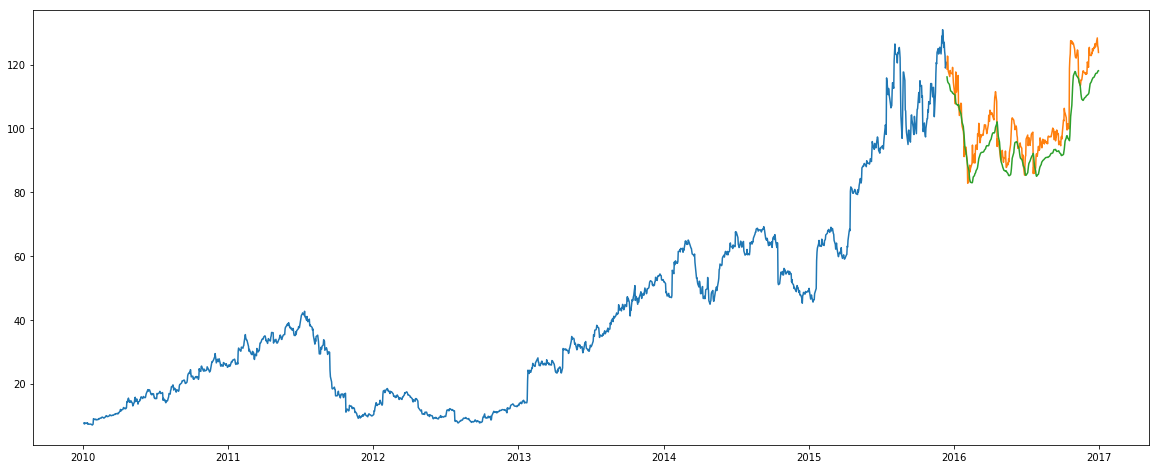

In [67]:
LSTM(df['NFLX'],0.85)

# Tripadvisor  (Ticker TRIP)

In [68]:
df['TRIP'].head()

Date       Open      Close        Low       High     Volume
354750  2013-01-02  42.939999  44.160000  42.799999  44.169998  2106600.0
355233  2013-01-03  44.090000  43.910000  43.450001  44.500000  1770400.0
355716  2013-01-04  44.009998  44.119999  43.400002  44.160000  1052300.0
356199  2013-01-07  44.029999  45.119999  43.750000  45.330002  1823800.0
356682  2013-01-08  44.849998  44.720001  44.270000  45.450001  2192300.0

# Plots and models fitting

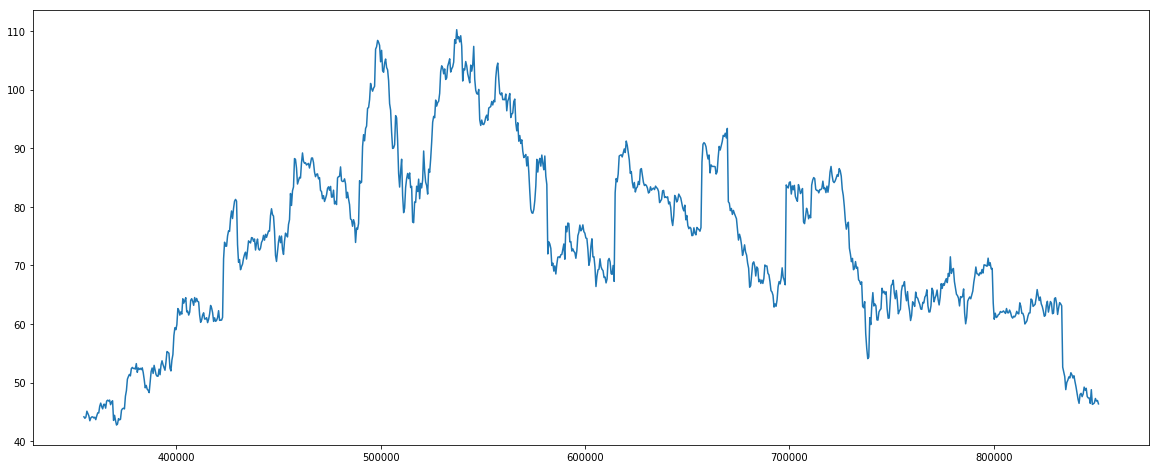

In [69]:
plt.figure(figsize=(20,8))
plt.plot(df["TRIP"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 9.680648281073319
Moving average r-squared score is : -0.8042103452644016


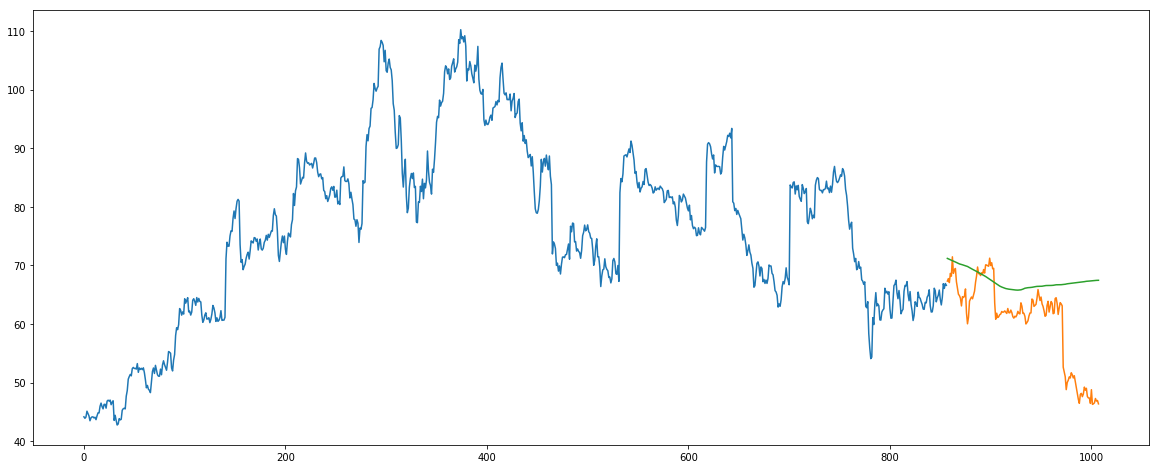

In [70]:
moving_average(df['TRIP'],0.85)

Linear Regression RMS score is :22.490030418329365
Linear Regression r-squared score is : -8.73774440992284


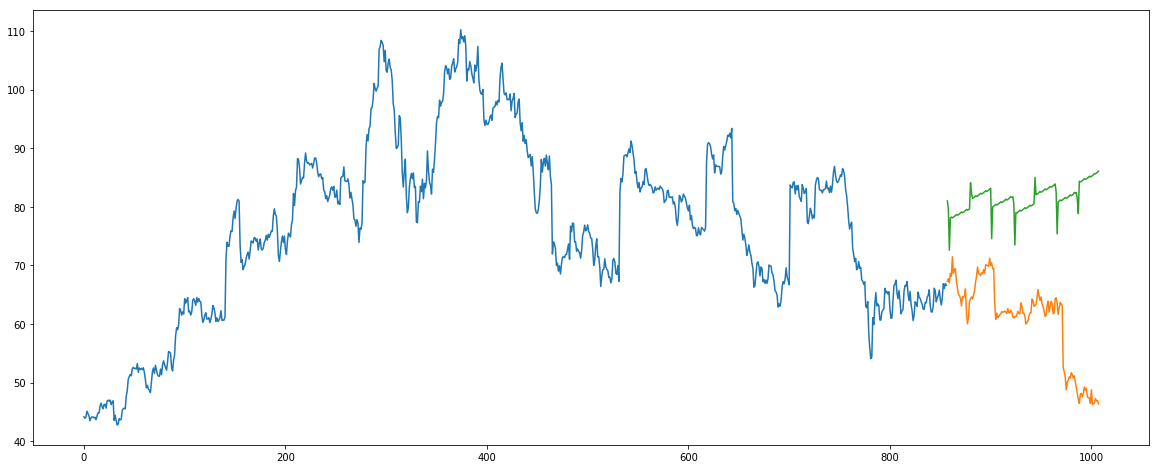

In [71]:
linear_regression(df['TRIP'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 20.259535436208026
Linear Regression r-squared score is : -6.902004098615555


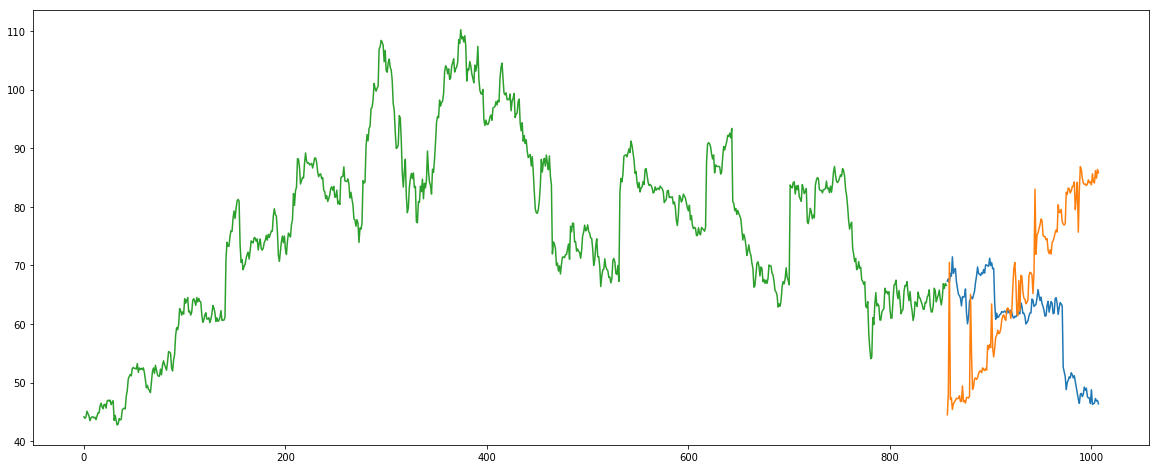

In [72]:
KNN(df['TRIP'],0.85)

Prophet RMS is : 6.663313534578587
R-squared score is : 0.14521127784035237


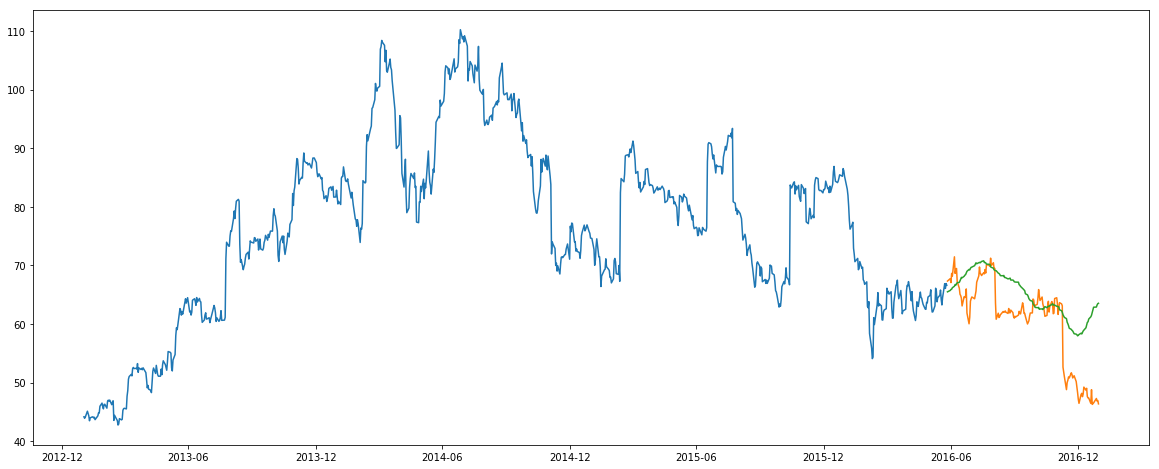

In [73]:
fbprophet(df['TRIP'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3603.398, BIC=3627.089, Fit time=28.872 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4108.515, BIC=4117.991, Fit time=0.444 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3874.122, BIC=3893.074, Fit time=4.513 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3601.567, BIC=3620.519, Fit time=15.215 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3602.150, BIC=3625.840, Fit time=20.839 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4106.539, BIC=4120.754, Fit time=0.771 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3602.242, BIC=3625.933, Fit time=46.832 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3603.572, BIC=3632.001, Fit time=71.967 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3600.546, BIC=3614.761, Fit time=13.647 seconds
Fit ARIMA: order=(0, 1

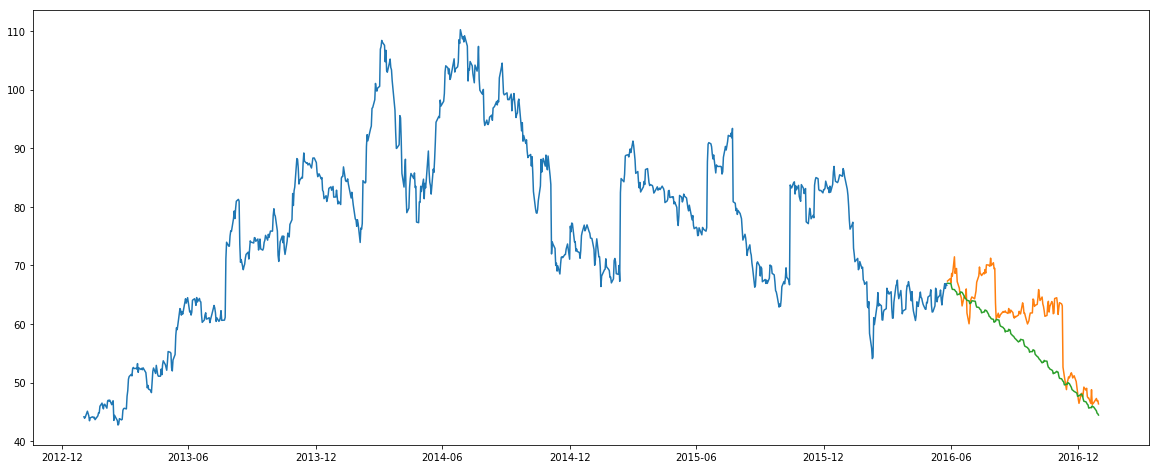

In [74]:
ARIMA(df['TRIP'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 89s - loss: 0.0056
LSTM 3.0656259875971195
LSTM r-squared score is : 0.8190674835267583


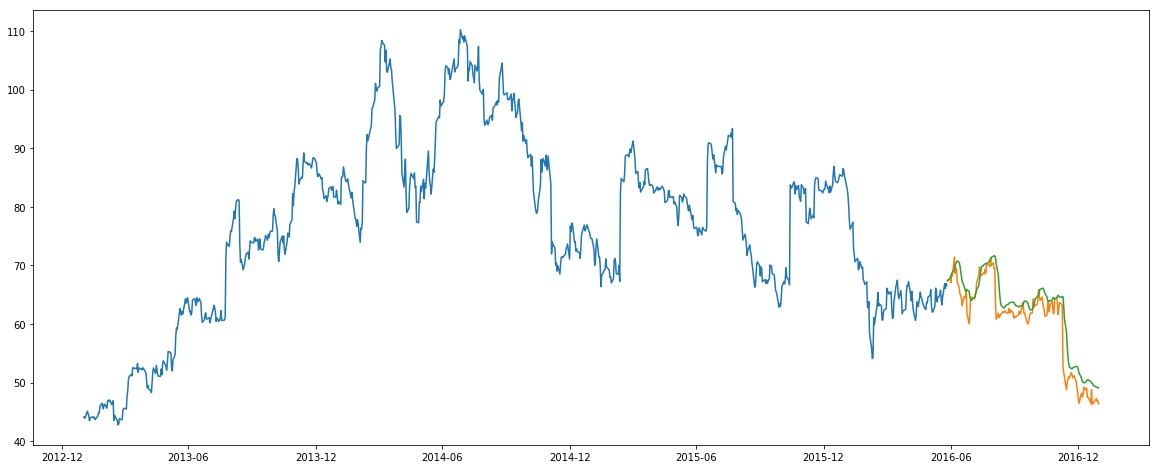

In [75]:
LSTM(df['TRIP'],0.85)

# Macy’s (Ticker M) 

In [76]:
df['M'].head()

Date       Open      Close        Low       High      Volume
518   2010-01-04  16.900000  17.059999  16.799999  17.350000   8823100.0
986   2010-01-05  17.020000  16.860001  16.790001  17.209999   9931300.0
1454  2010-01-06  16.950001  17.100000  16.870001  17.290001  13240700.0
1922  2010-01-07  17.540001  17.490000  16.959999  17.660000  19939600.0
2390  2010-01-08  17.139999  16.920000  16.850000  17.200001  13217600.0

# Plots and models fitting

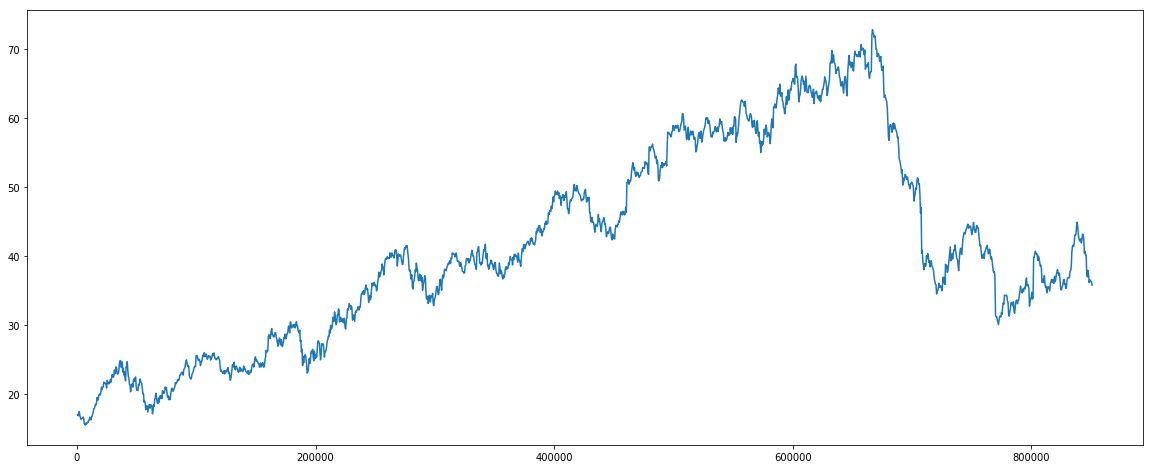

In [77]:
plt.figure(figsize=(20,8))
plt.plot(df["M"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 20.712994002620263
Moving average r-squared score is : -30.47978615463081


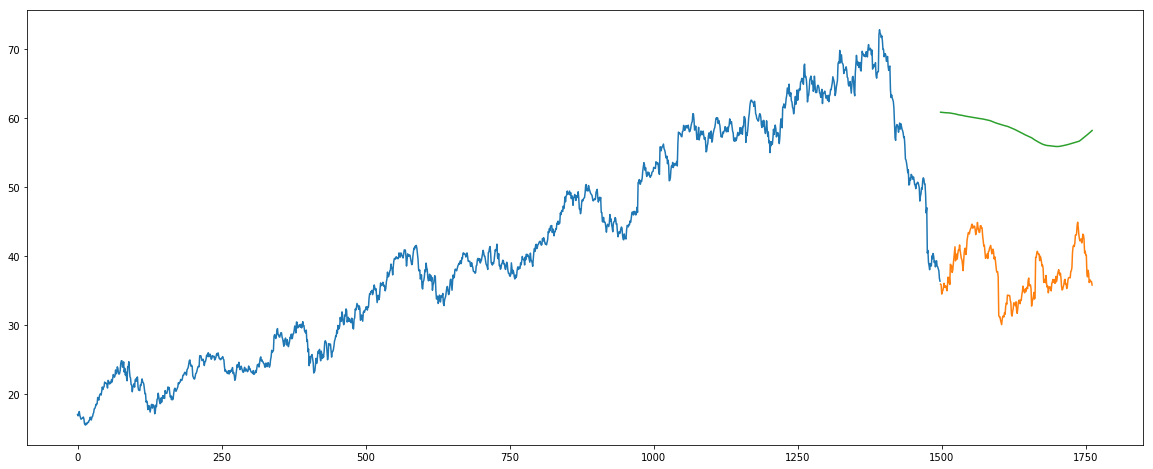

In [78]:
moving_average(df['M'],0.85)

Linear Regression RMS score is :32.837763200937346
Linear Regression r-squared score is : -78.12125151205845


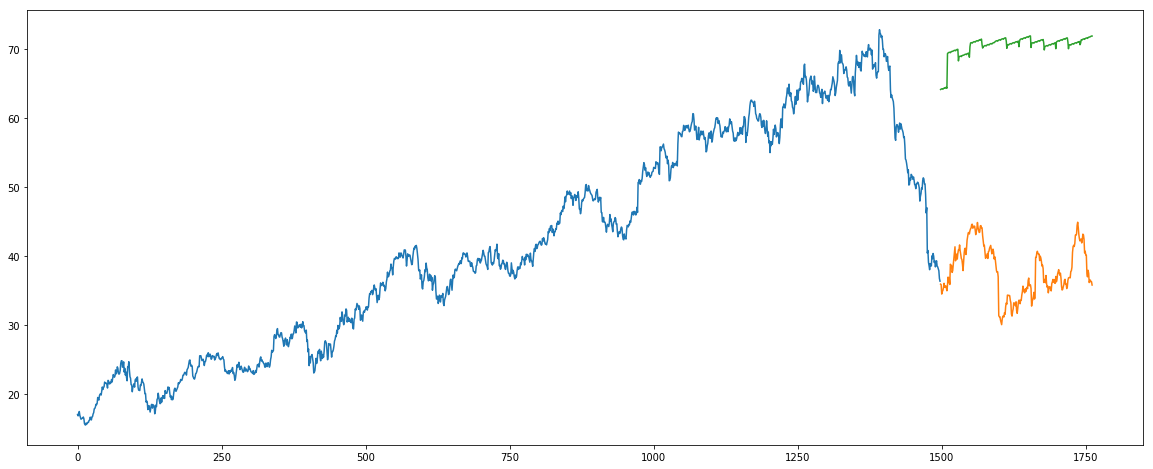

In [79]:
linear_regression(df['M'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 22.367048172774165
Linear Regression r-squared score is : -35.70822295769341


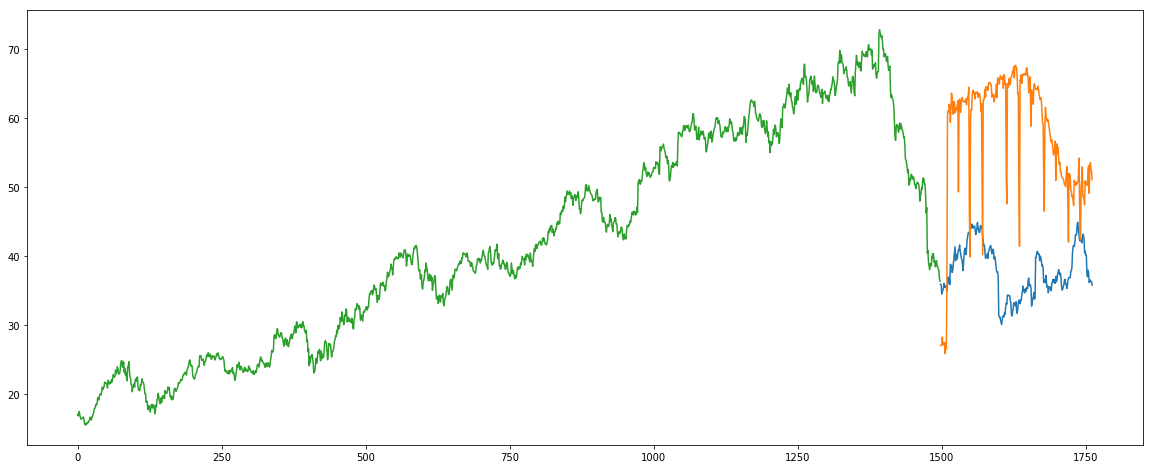

In [80]:
KNN(df['M'],0.85)

Prophet RMS is : 17.075304929372383
R-squared score is : -20.39355464145467


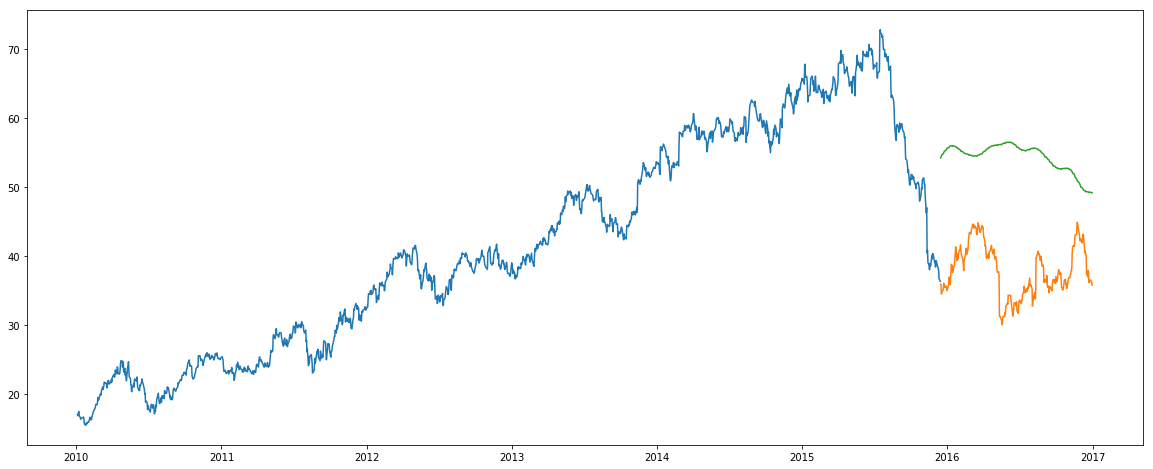

In [81]:
fbprophet(df['M'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3355.164, BIC=3381.680, Fit time=58.526 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4288.159, BIC=4298.765, Fit time=7.691 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3834.321, BIC=3855.534, Fit time=13.228 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3353.176, BIC=3374.388, Fit time=54.161 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3354.099, BIC=3380.615, Fit time=76.483 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4288.054, BIC=4303.963, Fit time=10.896 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3354.173, BIC=3380.689, Fit time=172.847 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3350.380, BIC=3382.199, Fit time=138.918 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3352.409, BIC=3389.532, Fit time=218.676 seconds
Fit ARIMA: order=

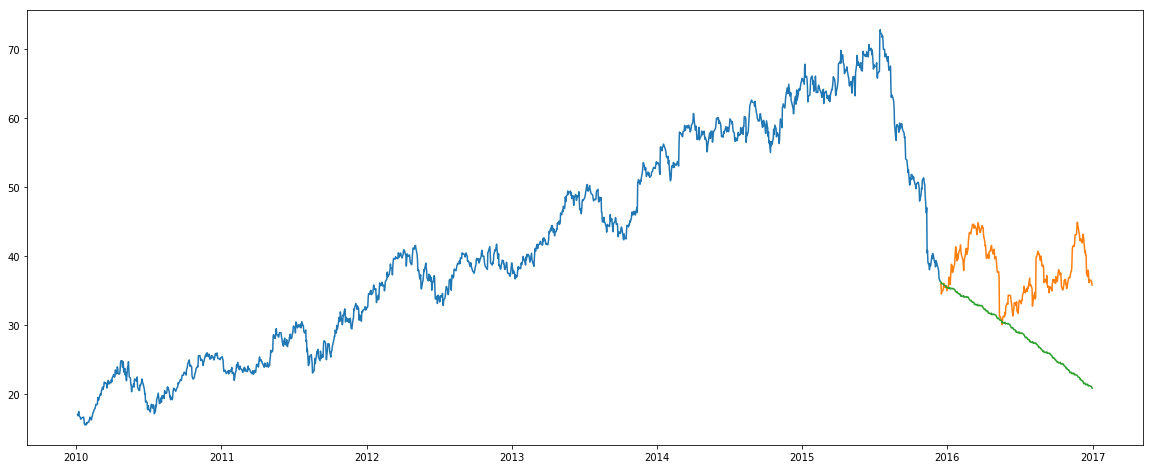

In [82]:
ARIMA(df['M'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 516s - loss: 0.0030
LSTM 2.2396575964130356
LSTM r-squared score is : 0.6319479256744429


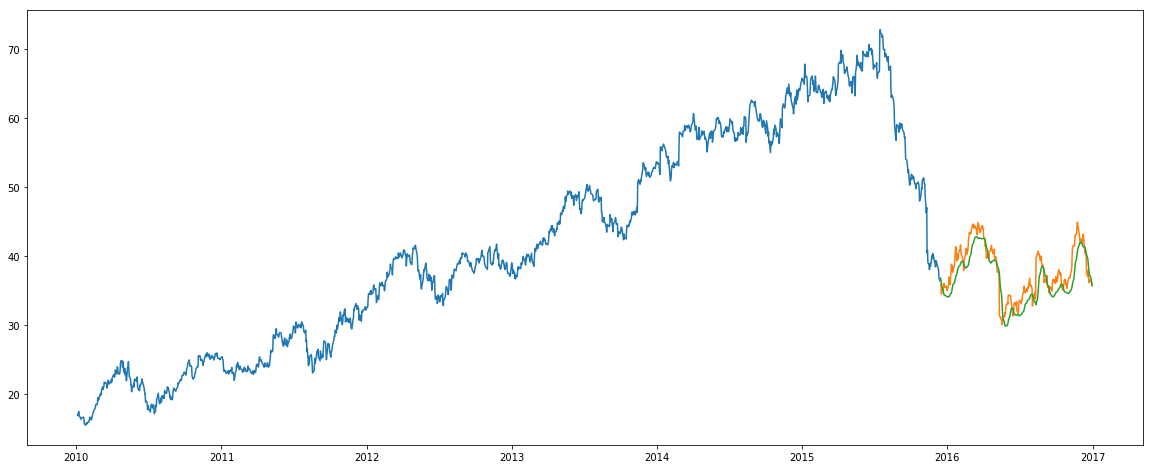

In [83]:
LSTM(df['M'],0.85)

# Red Hat (Ticker RHT)

In [84]:
df['RHT'].head()

Date       Open      Close        Low   High     Volume
611   2010-01-04  31.230000  31.120001  31.030001  31.50  2060800.0
1079  2010-01-05  31.170000  30.969999  30.770000  31.35  2116700.0
1547  2010-01-06  30.950001  30.969999  30.780001  31.42  2164200.0
2015  2010-01-07  30.980000  30.389999  30.340000  31.00  1900000.0
2483  2010-01-08  30.420000  30.139999  29.920000  30.42  2764500.0

# Plots and models fitting

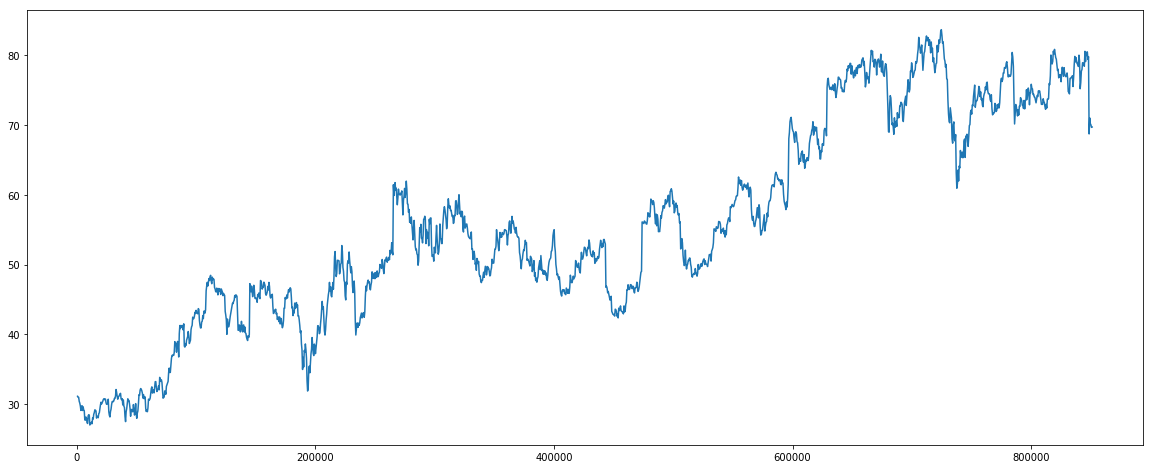

In [85]:
plt.figure(figsize=(20,8))
plt.plot(df["RHT"]['Close'], label='Closing Price ',linestyle="solid")

Moving average rms : 4.386324526100265
Moving average r-squared score is : -0.0795265661900415


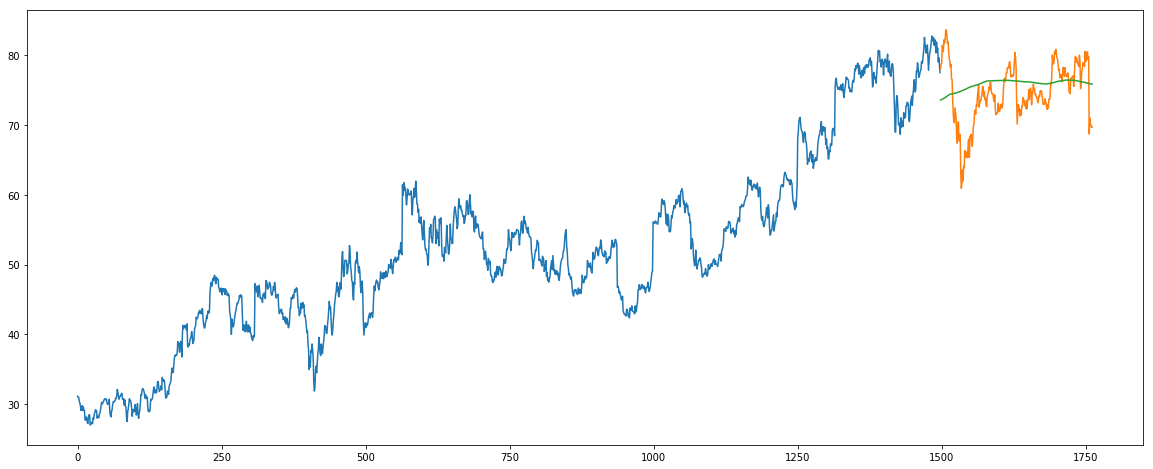

In [86]:
moving_average(df['RHT'],0.85)

Linear Regression RMS score is :4.783290760709679
Linear Regression r-squared score is : -0.2837645417446608


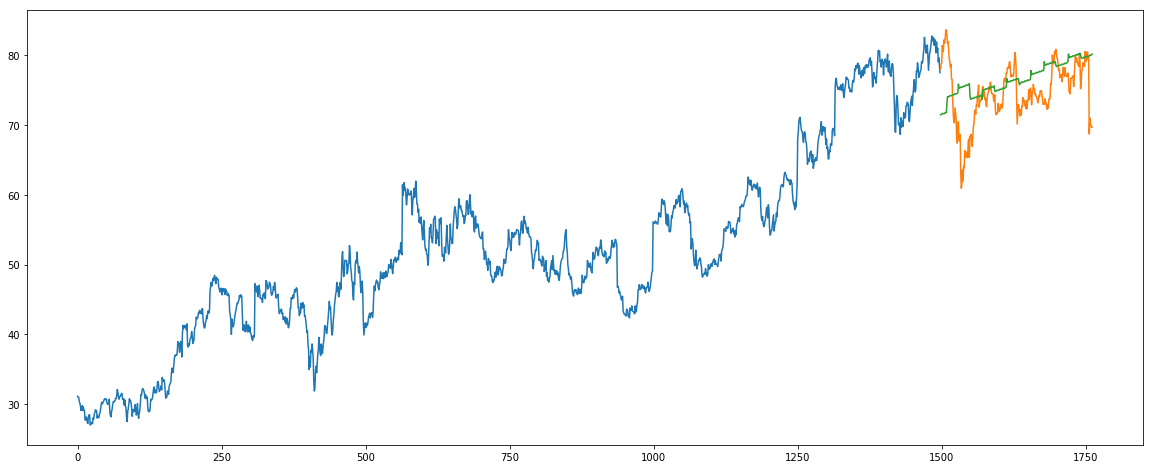

In [87]:
linear_regression(df['RHT'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


k nearest neighbors RMS : 11.426310470807213
Linear Regression r-squared score is : -6.325611023763456


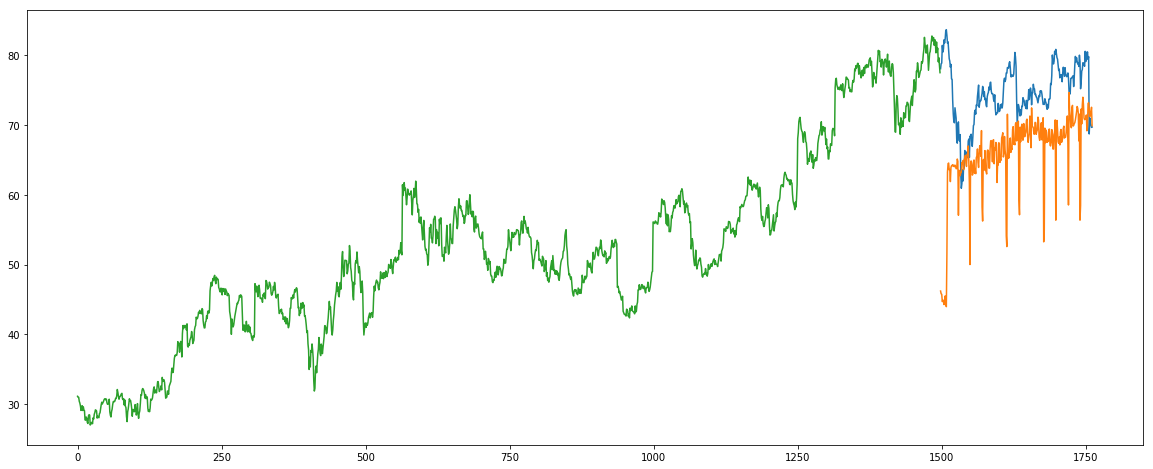

In [88]:
KNN(df['RHT'],0.85)

Prophet RMS is : 17.331786503059003
R-squared score is : -15.854600977981228


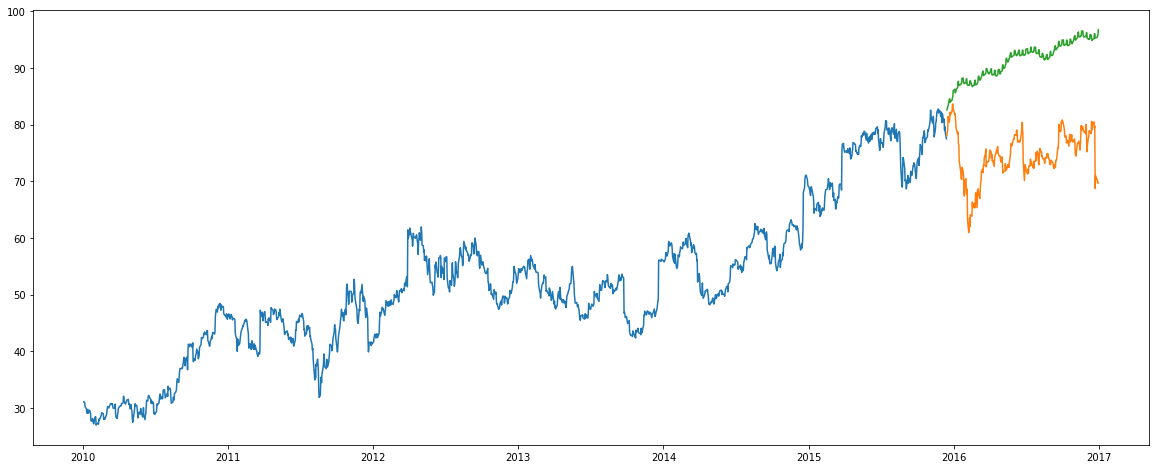

In [89]:
fbprophet(df['RHT'],0.85)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4394.186, BIC=4420.702, Fit time=43.421 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5360.339, BIC=5370.945, Fit time=13.652 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4908.623, BIC=4929.835, Fit time=41.967 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4392.822, BIC=4414.035, Fit time=90.489 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4394.806, BIC=4421.322, Fit time=80.555 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5361.209, BIC=5377.118, Fit time=10.663 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=4394.807, BIC=4421.323, Fit time=222.332 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4395.781, BIC=4427.600, Fit time=243.611 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4391.465, BIC=4407.375, Fit time=86.817 seconds
Fit ARIMA: order=

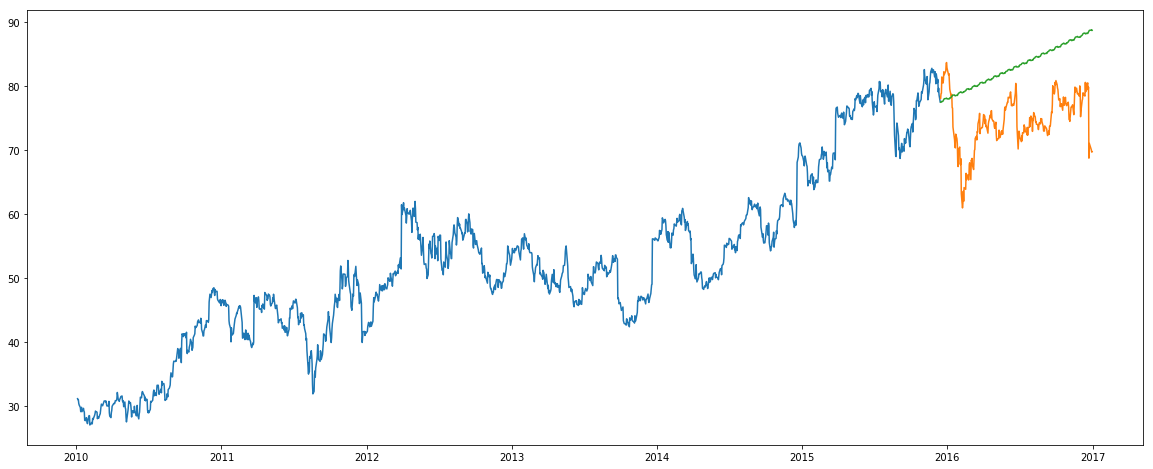

In [90]:
ARIMA(df['RHT'],0.85)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 367s - loss: 0.0025
LSTM 2.0040243080493236
LSTM r-squared score is : 0.7746602624697729


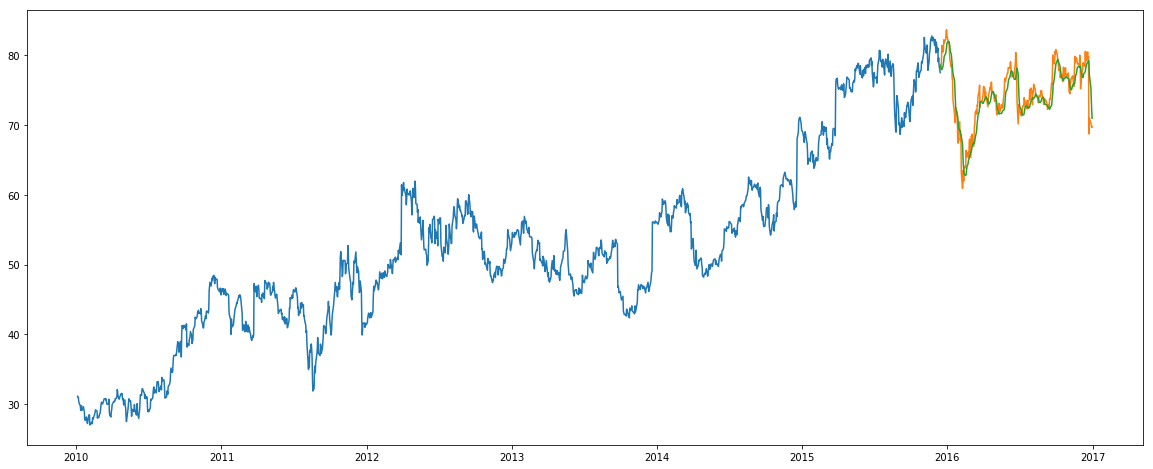

In [91]:
LSTM(df['RHT'],0.85)